In [1]:
%matplotlib inline
import io, os, sys, types

# Imports own outside scripts
import Databaseloader as dl
import loadinvizerfit as lif
import jsonwriter
import readandplotfits as rpf
import writereg as wr
import dbtools
import cutout as ct
#########################################
import json
import glob
import matplotlib
import loadjson as ljs
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import tkp.db
from astropy.coordinates import SkyCoord
from tkp.db.model import Varmetric
from tkp.db.model import Runningcatalog
from tkp.db.model import Newsource
from tkp.db.model import Extractedsource
from tkp.db.model import Image
import operator
from operator import itemgetter, attrgetter

import logging
import pandas as pd
from pandas import DataFrame
import sqlalchemy
from sqlalchemy import *
from sqlalchemy.orm import relationship
#import Tools
#import generic_tools
#import plotting_tools
from scipy.stats import norm
import pylab
pylab.rcParams['legend.loc'] = 'best'
from matplotlib.ticker import NullFormatter
from matplotlib.font_manager import FontProperties
#from astroML import density_estimation

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from scipy.spatial import distance
import scipy.stats as ss
import scipy.optimize as op
import scipy.integrate as si
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install bokeh
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import DatetimeTickFormatter
from bokeh.models import ColumnDataSource, Whisker
from bokeh.io import export_png
output_notebook()
matplotlib.rcParams.update({'errorbar.capsize': 2})
logging.basicConfig(level=logging.INFO)

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Loading BokehJS ...

In [2]:
engine = 'postgresql'
host = 'vlo.science.uva.nl'
port = 5432
user = 'kmeulen'
password = 'kLu2oepRouv2UfoUPhoU'
database='KmeulenTrap4P23'
websiteURL = 'http://banana.transientskp.org/r4/vlo_'+database+'/runningcatalog/'
latexURL = '\url{http://banana.transientskp.org/r4/vlo_'+database+'/runningcatalog/'
latexHREF = '\href{http://banana.transientskp.org/r4/vlo_'+database+'/runningcatalog/'
query_loglevel = logging.WARNING  # Set to INFO to see queries, otherwise WARNING

In [3]:
# this is sqlalchemy script to login to the Banana database
logging.getLogger('sqlalchemy.engine').setLevel(query_loglevel)
db = tkp.db.Database(engine=engine, host=host, port=port,
                     user=user, password=password, database=database)
db.connect()
session = db.Session()

# Here i get the peak flux and the error on the peak flux from all the sources in the database
fpeak = session.query(Extractedsource.f_peak).all()
fpeake = session.query(Extractedsource.f_peak_err).all()
califreq = np.load("freqlist.npy")
califlux = np.load("fluxlist.npy")

INFO:tkp.db.database:Database config: postgresql://kmeulen@vlo.science.uva.nl:5432/KmeulenTrap4P23
/home/kmeulen/virtualenv/local/lib/python2.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)
INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:connected to: postgresql://kmeulen@vlo.science.uva.nl:5432/KmeulenTrap4P23


Query to find the variability parameters of the sources in a specific dataset 

In [4]:
# Here I specifiy which dataset of the database to use
dataset_id = 5
timescale = "10min"
technique = "_P23"
savefigs = False
# runcat_id = 16077

# VarParams = session.query(Varmetric,Runningcatalog).select_from(join(Varmetric,Runningcatalog)).filter(Runningcatalog.dataset_id == dataset_id).all()
# imagecontrol = session.query(Runningcatalog,Image).filter(Runningcatalog.dataset_id == dataset_id).all()
session = dbtools.access(engine,host,port,user,password,database)
tables = ['image','varmetric','newsource']
PandasParams = dbtools.GetPandaExtracted(session,dataset_id,tables)

INFO:tkp.db.database:connecting to database...
INFO:tkp.db.database:connected to: postgresql://kmeulen@vlo.science.uva.nl:5432/KmeulenTrap4P23


connected!


In [5]:
# print len(VarParams)
# print len(imagecontrol)
# for i in imagecontrol:
#     print i
# print PandasParams.keys()
newPandas = PandasParams.drop_duplicates(subset='xtrsrc')

Make 2d array of all the sources except for the transients.

In [6]:
# plotdata = [[VarParams[i].Runningcatalog.id, VarParams[i].Runningcatalog.wm_ra,\
#              VarParams[i].Runningcatalog.wm_decl,VarParams[i].Runningcatalog.avg_ra_err,\
#              VarParams[i].Runningcatalog.avg_decl_err, VarParams[i].Runningcatalog.datapoints,\
#              session.query(Newsource).filter(Newsource.id==VarParams[i].Varmetric.newsource).one().newsource_type,\
#              VarParams[i].Varmetric.newsource,VarParams[i].Varmetric.lightcurve_max,
#              session.query(Newsource).filter(Newsource.id==VarParams[i].Varmetric.newsource).one().trigger_xtrsrc.id,VarParams[i].Varmetric.eta_int]\
#             for i in range(len(VarParams)) if VarParams[i].Varmetric.newsource != None]
# for i in plotdata:
#     if i[0] ==2877:
#         print i
print len(newPandas)

10123


In [7]:
plotdata = [[i.runcat, i.wm_ra,\
             i.wm_decl,i.avg_ra_err,\
             i.avg_decl_err, i.datapoints,\
             i.newsource_type,\
             i.newsource,i.lightcurve_max,
             i.xtrsrc,i.eta_int,i.url]\
            for index,i in newPandas.iterrows() if i.newsource != None]

In [8]:
print len(plotdata)
for i in plotdata:
    if i[0] ==2877:
#         print i[9]-1
        print i[11]
#         print fpeak[i[9]-1][0]


10123


In [9]:
# The de Ruiter distance as shown in the Trap Paper section 4.4 https://arxiv.org/abs/1503.01526 

def CalcDeRuiter(transient,ra2,ra2e,dec2,dec2e):

    ra1 = transient['ra']
    dec1 = transient['dec']
    ra1e = transient['rae']
    dec1e = transient['dece']


    r=(np.sqrt((((-1*ra2 +ra1)**2)*(np.cos((dec1+dec2)/2))**2)/\
                       (ra1e**2+ra2e**2)+((-1*dec2+dec1)**2/(dec1e**2+dec2e**2))))
    return r 

In [10]:
# Comparing the fluxes heavily inspired on the de Ruiter distance as used by Bart's thesis: https://api-alumni.nl/media/uploads/theses/phd/lha-scheers-phd.pdf page 55

def CompareFluxes(transient,pflux2,pflux2e,scale=1):
    pflux1 = transient['pflux']*scale
    pflux1e = transient['pfluxe']*scale
    
    r = np.sqrt((((-1*pflux2 +pflux1)**2))/\
                       (pflux1e**2+pflux2e**2))
    return r

In [11]:
# calculates the frequency flux scale based on supplied califreq and califlux data

def CalcFreqScale(transient,datafreq,califreq,califlux):
    """Function for calculating the frequency scale"""
    transfreq = transient.freq
    for i in range(len(califreq)):
        if transfreq - 0.005 <= califreq[i] <= transfreq + 0.005:
            oldflux = califlux[i]
        if datafreq - 0.005 <= califreq[i] <= datafreq + 0.005:
            newflux = califlux[i]
    scale = newflux/oldflux
    return scale

def CalcRelFlux(transient,datafreq,dataflux):
    transfreq = transient.freq
    scale = np.power((transfreq/datafreq),-0.7)*dataflux 
    return scale

Left off here <a name='bookmark' />

Go to <a href=#bookmark2>my bookmark</a>



Function for pruning our candidate list

Function for comparing transient candidate against external databases

In [12]:

def CheckSimOutsideDatabase(data,sources,rcheck,ycheck,checklight,gamma,Cali,deruiter = True,euccutoff = 0.06):
    """ Function for checking against outside database the data entry is for the database rcheck is condition \
where we check deruiter against, ycheck is where we check de flux against and checklight,gamma,deruiter\
are booleans which switch on checking the flux(checklight), checking using error on the flux(gamma) and \
using deruiter distance

"""
    masterindex = []
    savedilist = []
    print 'before:'
    if Cali:
        scale =  CalcFreqScale(sources[0],data.freq,califreq,califlux)
    else:
        scale = CalcRelFlux(sources[0],data.freq,data.pflux)

    print len(sources)

    for i in sources:
        indexlist = []

        if not deruiter:
            Y = distance.cdist(i.radec,data.radec,'euclidean')
            if gamma:
                y = CompareFluxes(i,np.array(data.pflux),np.array(data.pfluxe),scale)
                
                for g in Y:

                    for j in range(len(g)):

                        if g[j] <=euccutoff and y[j]>= ycheck:
                            if i.id not in savedilist:
                                FluxVar(vars(i),j,data,scale)
                                savedilist.append(i.id)
                            indexlist.append(j)

                        elif g[j] <=euccutoff:
                            indexlist.append(j)
                    
            else:
                for g in Y:

                    for j in range(len(g)):
                        if checklight:

                            if g[j] <=euccutoff and (i.pflux*scale <= 0.9*data.pflux[j] or i.pflux*scale>=1.1*data.pflux[j]):
                                if i.id not in savedilist:
                                    FluxVar(vars(i),j,data,scale)
                                    savedilist.append(i.id)
                                indexlist.append(j)

                            elif g[j] <=euccutoff:
                                indexlist.append(j)
                        else:
                            if g[j] <=euccutoff:
                                indexlist.append(j)

        else:
            r = CalcDeRuiter(vars(i),np.array(data.ra),np.array(data.rae),np.array(data.dec),np.array(data.dece))
            if gamma:
                y = CompareFluxes(vars(i),np.array(data.pflux),np.array(data.pfluxe),scale)

                for j in range(len(r)):

                    if r[j] <=rcheck:
                        indexlist.append([j,r[j]])
               
                if checklight and indexlist:
                    pfluxlist = []
                    pfluxelist = []
                    
                    indexvalue = np.argmin(np.array(indexlist)[:,1])
                    pfluxlist.append(data.pflux[indexlist[indexvalue][0]])
                    pfluxelist.append(data.pfluxe[indexlist[indexvalue][0]])
                    
                    y = CompareFluxes(vars(i),np.array(pfluxlist),np.array(pfluxelist))

                    
                    if y[0]>=ycheck:

                        FluxVar(vars(i),indexlist[indexvalue][0],data,scale)


            else:
                for j in range(len(r)):
                    if checklight:
                        if r[j] <=rcheck and (i.pflux*scale <= 0.9*data.pflux[j] or i.pflux*scale>=1.1*data.pflux[j]):
                            indexlist.append(j)
                            if i.id not in savedilist:
                                FluxVar(vars(i),j,data,scale)
                                savedilist.append(i.id)
                        elif r[j] <=rcheck:
                            indexlist.append(j)





                    else:
                        if r[j] <=rcheck:
                            indexlist.append(j)

        masterindex.append(indexlist)
    
#     check if thereis a zero listentry in masterindex.. if so append it to the varying pos sources class.
    i = 0
    while i < len(masterindex):
        if not masterindex[i]:
            PosVar(vars(sources[i]),data)
        i+=1

    print 'after:'  
    print str(len(PosVar.instances)) +" Interesting candidates"
    print str(len(FluxVar.instances)) + " Flux Varying candidates"


Class object for saving our candidate transients, class object for storing objects that have varying flux compared to external database and
Initialize our transients class and other banana sources lists.

(This piece of code has to be rerun everytime you adjust something)

In [13]:

class Transients(object):
    instances = []
    def __init__(self,ra,rae,dec,dece,ids,pflux,pfluxe,url):
        self.id = ids
        y = np.stack((ra,dec),axis = -1)
        self.url = url
        self.ra = ra
        self.rae = rae
        self.dec = dec
        self.dece = dece
        self.pflux = pflux
        self.pfluxe = pfluxe
        self.freq = 144
        self.keys = ['yoloswag']
        self.radec = np.reshape(y,(1,2))
        c = SkyCoord(self.ra, self.dec, frame='fk5', unit='deg')
        self.fk5 = c.to_string('hmsdms',sep=' ',precision= 0)
        self.c = c
        Transients.instances.append(self)

    def DelFalse(i):
        del Transients.instances[i]

class PosVar(object):
    """class object for storing objects that have a varying position compared to the database we are looking in"""
    instances = []
    def __init__(self,params,database):
        self.id = params['id']            
        self.ra = params['ra']
        self.url = params['url']
        self.database = database
        self.dataname = database.name
        self.dec = params['dec']
        self.radec = params['radec']
        self.pflux = params['pflux']
        c = SkyCoord(params['ra'], params['dec'], frame='fk5', unit='deg')
        self.fk5 = c.to_string('hmsdms',sep=' ',precision= 0)
        self.c = c
        try:
            self.iflux = params['iflux']
        except:
            pass
        PosVar.instances.append(self)
        

class TestInstance(object):
    """class object for storing objects that have a varying position compared to the database we are looking in"""
    instances = []
    def __init__(self,params):
        self.id = params['id']            
        self.ra = params['ra']
        self.url = params['url']
        self.database = params['database']
        self.dataname = params['dataname']
        self.dec = params['dec']
        self.radec = params['radec']
        self.pflux = params['pflux']
        c = SkyCoord(params['ra'], params['dec'], frame='fk5', unit='deg')
        self.fk5 = c.to_string('hmsdms',sep=' ',precision= 0)
        self.c = c
        try:
            self.iflux = params['iflux']
        except:
            pass
        TestInstance.instances.append(self)
        
class SavedFluxSources(object):
    """class object for storing objects that have a varying position compared to the database we are looking in"""
    instances = []
    def __init__(self,initialid,initialpflux,initialpfluxerr,params):
        self.id = params['id']            
        self.ra = params['ra']
        self.url = params['url']
        self.dec = params['dec']
        self.rae = params['rae']
        self.dece = params['dece']
        self.radec = params['radec']
        self.pflux = params['pflux']
        self.freq = params['freq']
        self.pfluxe = params['pfluxe']
        c = SkyCoord(params['ra'], params['dec'], frame='fk5', unit='deg')
        self.fk5 = c.to_string('hmsdms',sep=' ',precision= 0)
        self.c = c
        self.cmpid = initialid
        self.cmppflux = initialpflux
        self.cmppfluxerr = initialpfluxerr
        try:
            self.iflux = params['iflux']
        except:
            pass
        SavedFluxSources.instances.append(self)

class SavedPosSources(object):
    """class object for storing objects that have a varying position compared to the database we are looking in"""
    instances = []
    def __init__(self,params):
        self.id = params['id']            
        self.ra = params['ra']
        self.url = params['url']
        self.dec = params['dec']
        self.rae = params['rae']
        self.dece = params['dece']
        self.radec = params['radec']
        self.pflux = params['pflux']
        self.freq = params['freq']
        self.pfluxe = params['pfluxe']
        c = SkyCoord(params['ra'], params['dec'], frame='fk5', unit='deg')
        self.fk5 = c.to_string('hmsdms',sep=' ',precision= 0)
        self.c = c
        try:
            self.iflux = params['iflux']
        except:
            pass
        SavedPosSources.instances.append(self)  
    
class FluxVar(object):
    """class object for storing objects that have a varying flux compared to the database we are looking in"""
    instances = []
    def __init__(self,params,databaseentry,database,scale):
        self.id = params['id']
        self.ra = params['ra']
        self.url = params['url']
        self.database = database
        self.dataname = database.name
        self.scale = scale
        self.dec = params['dec']
        self.radec = params['radec']
        self.pflux = params['pflux']
        self.entry = databaseentry
        c = SkyCoord(params['ra'], params['dec'], frame='fk5', unit='deg')
        self.fk5 = c.to_string('hmsdms',sep=' ',precision= 0)
        self.c = c
        c = c.icrs
        self.icrs = c.to_string('hmsdms',sep=' ',precision= 0)
        try:
            self.iflux = params['iflux']
        except:
            pass
        FluxVar.instances.append(self)
    

        
racata = []
raecata = []
deccata = []
dececata = []
idcata = []
lightcata = []
lightecata = []
idstorelist = []
for i in range(len(plotdata)):
    if plotdata[i][0] in idstorelist:
        continue
    else:
        if plotdata[i][6] == 1:
            Transients(plotdata[i][1],plotdata[i][3],plotdata[i][2],plotdata[i][4],plotdata[i][0],fpeak[plotdata[i][9]-1][0],fpeake[plotdata[i][9]-1][0],[plotdata[i][11]])
        else:
            racata.append(plotdata[i][1])
            raecata.append(plotdata[i][3])
            deccata.append(plotdata[i][2])
            dececata.append(plotdata[i][4])
            idcata.append(plotdata[i][0])
#           -1 necessary to account for pythonic lists
            lightcata.append(fpeak[plotdata[i][9]-1][0])
            lightecata.append(fpeake[plotdata[i][9]-1][0])
        idstorelist.append(plotdata[i][0])
X = np.stack((racata,deccata),axis = -1)

racata = np.array(racata)
raecata = np.array(raecata)
dececata = np.array(dececata)
deccata = np.array(deccata)
idcata = np.array(idcata)
lightcata = np.array(lightcata)
lightecata = np.array(lightecata)


# Transients(183,0.01,45,0.01,99999999,1.32,0.001)

In [14]:
# rasl = []
# raesl = []
# decsl = []
# decesl = []
# idsl = []
# pfluxsl = []
# pfluxesl = []
# for i in range(len(plotdata)):
#     rasl.append(plotdata[i][1])
#     raesl.append(plotdata[i][3])
#     decsl.append(plotdata[i][2])
#     decesl.append(plotdata[i][4])
#     idsl.append(plotdata[i][0])
#     pfluxsl.append(fpeak[plotdata[i][9]-1][0])
#     pfluxesl.append(fpeake[plotdata[i][9]-1][0])



# raseries = pd.Series(racata)
# raseries
# ras = pd.Series(rasl, name='ra')
# raes = pd.Series(raesl, name='raerr')
# decs = pd.Series(decsl, name='dec')
# deces = pd.Series(decesl, name='decerr')
# ids = pd.Series(idsl, name='id')
# pfluxs = pd.Series(pfluxsl, name='pflux')
# pfluxes = pd.Series(pfluxesl, name='pfluxerr')

# pandacata = pd.concat([ras, raes,decs,deces,ids,pfluxs,pfluxes], axis=1)


here we call the function for calculating the de ruiter distance between candidates and our found sources and if True is given we also check if the max of the lightcurve of the sources compared fall withing 5 sigma flux of each other (thus making it increasingly likely for   the source to be a sidelobe)

This extra flux comparison is used in order to not potentially write of a faint or bright transient close to a known source.

In [15]:
def SelectorForCandidateslist(rcheck,ycheck,checklight,deruiter=True):
    """Function for pruning the candidate list using both distance and lightcurve measurements"""
    ctr = 0
    print 'before:'
    print len(Transients.instances)
    oldlen = len(Transients.instances) + 1
    
# #   Repeat until no improvement in the length of the candidate list
#     while len(Transients.instances) - oldlen < 0:
    ratlist = []
    detclist = []

    translist = []
#         rlist = []
    oldlen = len(Transients.instances)

#         These lists are necessary to compare the candidate Transientss against each other
    ralist = []
    raelist = []
    declist = []
    decelist = []

# """Check candidate Transientss against each other"""

    for h in Transients.instances:
        if not deruiter:
            translist.append(h.radec)
        else:
            ralist.append(h.ra)
            raelist.append(h.rae)
            declist.append(h.dec)
            decelist.append(h.dece)
            

    masterindex = []
    savedlist = []
    first = True
    for i in Transients.instances:
        nocount = False
        indexlist = []


# #             again the outdated euclidean method
#         if not deruiter:
#             Y = distance.cdist(i.radec,X,'euclidean')

#             for g in Y:
#                 for j in range(len(g)):
#                     if checklight:
#                         if g[j] <=0.06 and 0.8*lightcata[j]<=i.pflux <= 1.2*lightcata[j]:
#                             indexlist.append(j)
#                     else:
#                         if g[j] <=0.06:
#                             indexlist.append(j)

#             the de Ruiter method 
#         else:
        r = CalcDeRuiter(vars(i),np.array(ralist),\
        np.array(raelist),np.array(declist),np.array(decelist))
        y = CompareFluxes(vars(i),np.array(lightcata),np.array(lightecata))
        for j in range(len(r)):

            if r[j] <=rcheck and r[j]!=0.0:
                indexlist.append(j)
                nocount = True
                        
#         SAVE ENTRIES THAT HAVE A BIG DIFFERENCE ON FLUX
        if checklight:
            pfluxlist = []
            pfluxelist = []
            for z in indexlist:            
                pfluxlist.append(Transients.instances[z].pflux)
                pfluxelist.append(Transients.instances[z].pfluxe)

            y = CompareFluxes(vars(i),np.array(pfluxlist),np.array(pfluxelist))
            
            if first:
                print y
                first = False
                try:
                    print Transients.instances[indexlist[0]].id
                except:
                    pass
            for o in range(len(y)):
                if y[o]>=ycheck:
                    SavedFluxSources(i.id,i.pflux,i.pfluxe,vars(Transients.instances[indexlist[o]]))
                    break
                    
                 
#         DELETE DOUBLE ENTRIES reform lists
        if nocount:
            k = 0
            g = 0
            while k < len(indexlist):
                del Transients.instances[indexlist[k]-g]

                k+=1
                g+=1

            ralist = []
            raelist = []
            declist = []
            decelist = []

            for h in Transients.instances:
                ralist.append(h.ra)
                raelist.append(h.rae)
                declist.append(h.dec)
                decelist.append(h.dece)


    print 'after:'
#     add back the no duplicate detections
#     for i in SavedPosSources.instances:
#         TestInstance(vars(i))
    print len(Transients.instances)
    print len(SavedFluxSources.instances)



In [16]:
SelectorForCandidateslist(rcheck = 3, ycheck = 3,checklight = True, deruiter = True)


before:
602
[7.87674705 5.38625421 5.63852146 9.05014773 1.1380969  0.57419744
 4.18896759 1.02361606 3.19552575 0.5353681  4.94998073 1.78830682
 1.42882112 0.92997174]
7294
after:
50
37


print out in latex format:

In [17]:
try:
    print SavedFluxSources.instances[0].pflux
    print Transients.instances[0].pflux
except:
    pass
FluxVar.instances = []
PosVar.instances = []

0.838205717429
0.731947945004


Go to <a href=#bookmark>my bookmark</a>
Left off here <a name='bookmark2' />

# tgss 
is the object which has tggs survey data for the field of P23 loaded into it.
could probably just automate it here but lets leave it for now

In [18]:
tgsslist = dl.ReadData("tgss")
tgss = tgsslist[1]
print tgss.keys
print tgss.freq
print tgss.name
print len(tgss.ra)
print np.mean(tgss.rae)

['name', 'radec', 'ra', 'rae', 'dec', 'dece', 'pflux', 'pfluxe', 'freq']
147.5
tgss
98604
0.0006028485434442595


In [19]:
CheckSimOutsideDatabase(tgss,Transients.instances,rcheck = 3,ycheck = 3,\
                     checklight = True, gamma = True,Cali = True,deruiter = True,euccutoff = .06)

before:
50
after:
5 Interesting candidates
13 Flux Varying candidates


In [20]:
print Transients.instances[0].fk5
print Transients.instances[0].c


12 09 45 +46 55 17
<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (182.43591353, 46.92133653)>


## VLSSr

In [21]:
# TODO fix the error for the vlssr data
 
# Probably need to pip install xlrd for excell support in pandas
vlssr = dl.ReadData('vlssr')[0]

print vlssr.keys
print vlssr.freq
print vlssr.ra

vlssrdataset.xls
*** No CODEPAGE record, no encoding_override: will use 'ascii'
*** No CODEPAGE record, no encoding_override: will use 'ascii'
*** No CODEPAGE record, no encoding_override: will use 'ascii'
*** No CODEPAGE record, no encoding_override: will use 'ascii'
['name', 'radec', 'ra', 'rae', 'dec', 'dece', 'pflux', 'pfluxe', 'freq']
74
[185.2953 184.7767 185.0477 ... 214.8349 165.3226 213.6304]


In [22]:

CheckSimOutsideDatabase(vlssr,Transients.instances,rcheck = 3 ,ycheck = 3,checklight = True,\
                     gamma = True,Cali=True,deruiter = True,euccutoff = 0.06)

before:
50
after:
10 Interesting candidates
46 Flux Varying candidates


In [23]:

savedpos = []
savedflux = []
print len(PosVar.instances)
print len(FluxVar.instances)
for i in PosVar.instances:
    if i.id not in savedpos:
        savedpos.append(i.id)
for i in FluxVar.instances:
    if i.id not in savedflux:
        savedflux.append(i.id)
        
print len(savedpos)
print len(savedflux)

10
46
5
36


## Print saved flux sources LATEX

In [24]:
print "\\begin{longtable}{c|c|c|c|c|c|c|c|c|c} \n\
\\toprule \n Id & Ra (deg) & Dec (deg) & Fk5 & Flux & Fluxerr & cmpId & cmpFlux & cmpFluxerr & Candidate? (y/n)  \\\\\\midrule \n\\endfirsthead \n\\toprule \
\n Id & Ra (deg) & Dec (deg) & Fk5 & Flux & Fluxerr & cmpId & cmpFlux & cmpFluxerr & Candidate? (y/n)  \\\\\\midrule \n\\endhead \n\\bottomrule \n\\endfoot \n\\bottomrule"

# define caption for table
print "\\caption{ SAVED FLUX SOURCES} \n\\endlastfoot"
for i in SavedFluxSources.instances:
    print latexHREF + str(i.id) +"}{%i}" %(i.id)+ " " + "&"+ " " + '%0.3f' %i.ra + " " + "&"+ " "+ "%0.3f" %(i.dec) +\
    " " + "&" + i.fk5+"&" + " " + '%0.3f' %(i.pflux) +"&" + " " + '%0.3f' %(i.pfluxe) +"&" + " " +\
    latexHREF + str(i.cmpid) +"}{%i}" %(i.cmpid)\
    +"&" + " " +'%0.3f' %(i.cmppflux) +"&" + " "\
    + '%0.3f' %(i.cmppfluxerr) +"&" + " " +"\\" + "\\"
print "\\end{longtable}"

\begin{longtable}{c|c|c|c|c|c|c|c|c|c} 
\toprule 
 Id & Ra (deg) & Dec (deg) & Fk5 & Flux & Fluxerr & cmpId & cmpFlux & cmpFluxerr & Candidate? (y/n)  \\\midrule 
\endfirsthead 
\toprule 
 Id & Ra (deg) & Dec (deg) & Fk5 & Flux & Fluxerr & cmpId & cmpFlux & cmpFluxerr & Candidate? (y/n)  \\\midrule 
\endhead 
\bottomrule 
\endfoot 
\bottomrule
\caption{ SAVED FLUX SOURCES} 
\endlastfoot
\href{http://banana.transientskp.org/r4/vlo_KmeulenTrap4P23/runningcatalog/7294}{7294} & 182.437 & 46.921 &12 09 45 +46 55 16& 0.838& 0.010& \href{http://banana.transientskp.org/r4/vlo_KmeulenTrap4P23/runningcatalog/10792}{10792}& 0.732& 0.009& \\
\href{http://banana.transientskp.org/r4/vlo_KmeulenTrap4P23/runningcatalog/9963}{9963} & 189.857 & 47.469 &12 39 26 +47 28 07& 0.747& 0.024& \href{http://banana.transientskp.org/r4/vlo_KmeulenTrap4P23/runningcatalog/6880}{6880}& 0.942& 0.026& \\
\href{http://banana.transientskp.org/r4/vlo_KmeulenTrap4P23/runningcatalog/7703}{7703} & 183.663 & 50.114 &12 14 39 

# Print the same position Fluxvariating sources

In [25]:
for i in FluxVar.instances:
    
    print "Data compared to " + i.database.name
    print i.id
    print websiteURL+str(i.id)
    print 'bananaflux: ' + str(i.pflux*i.scale)

    print i.database.name+'flux: ' + str(i.database.pflux[i.entry])
    print i.database.ra[i.entry]
    print i.database.dec[i.entry]
    print "------------------------"
        
#     if i.database == 'vssr':
        
#         print 'bananaflux: ' + str(i.pflux * vlssrscale)
#         print 'vlssrflux: ' + str(vssr.pflux[i.entry])
#         print "########################"
#     print vssr.ra[i.entry]
#     print vssr.dec[i.entry]
#     print i.ra
#     print i.dec

Data compared to tgss
10792
http://banana.transientskp.org/r4/vlo_KmeulenTrap4P23/runningcatalog/10792
bananaflux: 0.7197889862132293
tgssflux: 1.1515
182.43755
46.92069
------------------------
Data compared to tgss
10869
http://banana.transientskp.org/r4/vlo_KmeulenTrap4P23/runningcatalog/10869
bananaflux: 0.9739876761756237
tgssflux: 1.634
183.65923999999998
50.11296
------------------------
Data compared to tgss
6622
http://banana.transientskp.org/r4/vlo_KmeulenTrap4P23/runningcatalog/6622
bananaflux: 1.904179739521072
tgssflux: 1.4267999999999998
187.2155
48.96714
------------------------
Data compared to tgss
6786
http://banana.transientskp.org/r4/vlo_KmeulenTrap4P23/runningcatalog/6786
bananaflux: 0.7804115857559616
tgssflux: 1.3365
182.76134
45.65354
------------------------
Data compared to tgss
11194
http://banana.transientskp.org/r4/vlo_KmeulenTrap4P23/runningcatalog/11194
bananaflux: 1.6812540366958513
tgssflux: 3.7626999999999997
183.37238
48.38688
------------------------

# Print the same position Fluxvariating sources in Latex ready format

In [26]:

# SEPERATE DATABASES
databaselist = ['tgss','vlssr']

samesieslist = []
for i in range(len(FluxVar.instances)):
    samesie = False
    tempdict = {'tgss':None,'vlssr':None,'id':None,'ra':None,'dec':None,'fk5':None}
    
#   create combined name if entry both in vlssr and tgss
    for j in range(len(samesieslist)):
        if FluxVar.instances[i].id == samesieslist[j]['id']:
#             samesieslist[j].append(FluxVar.instances[i])
            samesieslist[j][FluxVar.instances[i].database.name] = FluxVar.instances[i]
          
            samesie = True
    if not samesie:
        tempdict[FluxVar.instances[i].database.name] = FluxVar.instances[i]
        tempdict['id'] = FluxVar.instances[i].id
        tempdict['ra'] = FluxVar.instances[i].ra
        tempdict['dec'] = FluxVar.instances[i].dec
        tempdict['fk5'] = FluxVar.instances[i].fk5
        samesieslist.append(tempdict)


print "\\begin{longtable}{c|c|c|c|c|c|c|c|c|c|c|c|c} \n\
\\toprule \nFlux147.5MHz (Jy) & Tgss (Jy) & Flux74MHz (Jy)& Vlssr (Jy) & fk5 & Ra (deg) & Dec (deg) &tggsRa&tgssDec&\
vlssrRa&vlssrDec& Id/Link & (y/n)  \\\\\\midrule \n\\endfirsthead \n\\toprule \
\nFlux147.5MHz (Jy) & Tgss (Jy) & Flux74MHz (Jy)& Vlssr (Jy)& fk5 & Ra (deg) & Dec (deg)  &tggsRa&tgssDec&\
vlssrRa&vlssrDec& Id/Link & (y/n) \\\\\\midrule \n\\endhead \n\\bottomrule \n\\endfoot \n\\bottomrule"

# define caption for table
print "\\caption{ Comparison of variable fluxes with the same position for different databases 1hr} \n\\endlastfoot"
lastname = None
# samesieslist = sorted(samesieslist, key=lambda e: (e['ra'], e['dec']))
for i in samesieslist:
    a= ''
    b=''
    for j in(databaselist):
        try: 
            a+= str(np.around(i[j].pflux*i[j].scale,3)) + " " + "&"+ " "
        except:
            a += "-" +" "+ "&"+ " "
        try:
            a+= str(np.around(i[j].database.pflux[i[j].entry],3)) + " " + "&"+ " "   
        except:
            a += "-" +" "+ "&"+ " "
            
        try: 
            b+= '%0.3f' %(i[j].database.ra[i[j].entry])+" "+"&"+" "
            b+= '%0.3f' %(i[j].database.dec[i[j].entry])+" "+"&"+" "
        except:
            b+= "-" + " " + "&"+" " "-" + " " + "&"+" "
        
    a +=i['fk5'] + " " + '&' + "  "+ '%0.3f' %i['ra'] + " " + "&"+ " "+ "%0.3f" %i['dec'] \
    + " " + '&' + "  "+ b+ latexHREF +str(i["id"])+"}" + "{%i}" %i['id'] +" "+"&"+" "+  "\\" + "\\"
    print a

print "\\end{longtable}"

\begin{longtable}{c|c|c|c|c|c|c|c|c|c|c|c|c} 
\toprule 
Flux147.5MHz (Jy) & Tgss (Jy) & Flux74MHz (Jy)& Vlssr (Jy) & fk5 & Ra (deg) & Dec (deg) &tggsRa&tgssDec&vlssrRa&vlssrDec& Id/Link & (y/n)  \\\midrule 
\endfirsthead 
\toprule 
Flux147.5MHz (Jy) & Tgss (Jy) & Flux74MHz (Jy)& Vlssr (Jy)& fk5 & Ra (deg) & Dec (deg)  &tggsRa&tgssDec&vlssrRa&vlssrDec& Id/Link & (y/n) \\\midrule 
\endhead 
\bottomrule 
\endfoot 
\bottomrule
\caption{ Comparison of variable fluxes with the same position for different databases 1hr} 
\endlastfoot
0.72 & 1.152 & 1.138 & 1.866 & 12 09 45 +46 55 17 &  182.436 & 46.921 &  182.438 & 46.921 & 182.437 & 46.921 & \href{http://banana.transientskp.org/r4/vlo_KmeulenTrap4P23/runningcatalog/10792}{10792} & \\
0.974 & 1.634 & 1.54 & 2.609 & 12 14 37 +50 06 42 &  183.654 & 50.112 &  183.659 & 50.113 & 183.659 & 50.115 & \href{http://banana.transientskp.org/r4/vlo_KmeulenTrap4P23/runningcatalog/10869}{10869} & \\
1.904 & 1.427 & - & - & 12 28 52 +48 58 01 &  187.216 & 4

# Print the Position variating sources in Latex ready format

In [27]:
# SEPERATE DATABASES

print "\\begin{longtable}{c|c|c|c|c|c} \n\
\\toprule \nDatabase & Ra (deg) & Dec (deg) & Fk5 & Id/Link & Candidate? (y/n)  \\\\\\midrule \n\\endfirsthead \n\\toprule \
\nDatabase & Ra (deg) & Dec (deg) & Fk5 & Id/Link & Candidate? (y/n)  \\\\\\midrule \n\\endhead \n\\bottomrule \n\\endfoot \n\\bottomrule"

# define caption for table
print "\\caption{ Comparison position of candidates with different databases for the 10 min interval data} \n\\endlastfoot"
lastname = None
for i in PosVar.instances:
    if i.database.name != lastname and lastname:
        print "\\hline"
    print i.database.name +" "+ "&"+ " " + '%0.3f' %i.ra + " " + "&"+ " "+ "%0.3f" %i.dec +\
    " " + "&" + " " + i.fk5 +" " + '&' + "  "+ latexHREF +str(i.id)+"}" + "{%i}" %i.id +" " + '&' + "  "+"\\" + "\\"
    
    lastname = i.database.name

print "\\end{longtable}"

\begin{longtable}{c|c|c|c|c|c} 
\toprule 
Database & Ra (deg) & Dec (deg) & Fk5 & Id/Link & Candidate? (y/n)  \\\midrule 
\endfirsthead 
\toprule 
Database & Ra (deg) & Dec (deg) & Fk5 & Id/Link & Candidate? (y/n)  \\\midrule 
\endhead 
\bottomrule 
\endfoot 
\bottomrule
\caption{ Comparison position of candidates with different databases for the 10 min interval data} 
\endlastfoot
tgss & -176.475 & 50.479 & 12 14 06 +50 28 44 &  \href{http://banana.transientskp.org/r4/vlo_KmeulenTrap4P23/runningcatalog/15972}{15972} &  \\
tgss & -173.524 & 44.939 & 12 25 54 +44 56 22 &  \href{http://banana.transientskp.org/r4/vlo_KmeulenTrap4P23/runningcatalog/16130}{16130} &  \\
tgss & -171.723 & 45.484 & 12 33 07 +45 29 01 &  \href{http://banana.transientskp.org/r4/vlo_KmeulenTrap4P23/runningcatalog/16216}{16216} &  \\
tgss & -175.262 & 50.444 & 12 18 57 +50 26 37 &  \href{http://banana.transientskp.org/r4/vlo_KmeulenTrap4P23/runningcatalog/16306}{16306} &  \\
tgss & -174.211 & 44.590 & 12 23 09 +44

In [28]:
# COMBINED DATABASES (SLOWER)

samesieslist = []
for i in range(len(PosVar.instances)):
    samesie = False
    
#   create combined name if entry both in vlssr and tgss
    for j in range(len(samesieslist)):
        if PosVar.instances[i].id == samesieslist[j][0]:
            samesieslist[j][1] = samesieslist[j][1] + " \& " + PosVar.instances[i].database.name
            samesie = True
    if not samesie:
        samesieslist.append([PosVar.instances[i].id,PosVar.instances[i].database.name,PosVar.instances[i]])
    
samesieslist = sorted(samesieslist, key=itemgetter(1))

print "\\begin{longtable}{c|c|c|c|c|c} \n\
\\toprule \nDatabase & Ra (deg) & Dec (deg)& Fk5 & Id/Link & Candidate? (y/n)  \\\\\\midrule \n\\endfirsthead \n\\toprule \
\nDatabase & Ra (deg) & Dec (deg) & Fk5 &Id/Link & Candidate? (y/n)  \\\\\\midrule \n\\endhead \n\\bottomrule \n\\endfoot \n\\bottomrule"

# define caption for table
print "\\caption{ Comparison position of candidates with different databases for the 1hr interval data} \n\\endlastfoot"
lastname = None
for i in samesieslist:
    if i[1] != lastname and lastname:
        print "\\hline"
    print i[1] +" "+ "&"+ " "+ '%0.3f' %i[2].ra + " " + "&"+ " "+ "%0.3f" %(i[2].dec) +\
    " " + "&" + " " +i[2].fk5 +" " + '&' + "  "+ latexHREF +str(i[0])+"}" + "{%i}" %i[0] +" " + '&' + "  "+"\\" + "\\"
    
    lastname = i[1]

print "\\end{longtable}"

\begin{longtable}{c|c|c|c|c|c} 
\toprule 
Database & Ra (deg) & Dec (deg)& Fk5 & Id/Link & Candidate? (y/n)  \\\midrule 
\endfirsthead 
\toprule 
Database & Ra (deg) & Dec (deg) & Fk5 &Id/Link & Candidate? (y/n)  \\\midrule 
\endhead 
\bottomrule 
\endfoot 
\bottomrule
\caption{ Comparison position of candidates with different databases for the 1hr interval data} 
\endlastfoot
tgss \& vlssr & -176.475 & 50.479 & 12 14 06 +50 28 44 &  \href{http://banana.transientskp.org/r4/vlo_KmeulenTrap4P23/runningcatalog/15972}{15972} &  \\
tgss \& vlssr & -173.524 & 44.939 & 12 25 54 +44 56 22 &  \href{http://banana.transientskp.org/r4/vlo_KmeulenTrap4P23/runningcatalog/16130}{16130} &  \\
tgss \& vlssr & -171.723 & 45.484 & 12 33 07 +45 29 01 &  \href{http://banana.transientskp.org/r4/vlo_KmeulenTrap4P23/runningcatalog/16216}{16216} &  \\
tgss \& vlssr & -175.262 & 50.444 & 12 18 57 +50 26 37 &  \href{http://banana.transientskp.org/r4/vlo_KmeulenTrap4P23/runningcatalog/16306}{16306} &  \\
tgss \& 

In [29]:
jsonwriter.WriteFluxJson(FluxVar.instances)



In [30]:
try:
    os.remove('neat.json')
except:
    print 'allready removed'
!{sys.executable} -m scrapy runspider scrapper.py -o neat.json
dfFlux = ljs.Loadin()

/home/kmeulen/virtualenv/local/lib/python2.7/site-packages/cryptography/hazmat/primitives/constant_time.py:26: CryptographyDeprecationWarning: Support for your Python version is deprecated. The next version of cryptography will remove support. Please upgrade to a 2.7.x release that supports hmac.compare_digest as soon as possible.
  utils.DeprecatedIn23,
2018-10-12 16:36:27 [scrapy.utils.log] INFO: Scrapy 1.5.1 started (bot: scrapybot)
2018-10-12 16:36:27 [scrapy.utils.log] INFO: Versions: lxml 4.2.5.0, libxml2 2.9.8, cssselect 1.0.3, parsel 1.5.0, w3lib 1.19.0, Twisted 18.7.0, Python 2.7.6 (default, Nov 23 2017, 15:49:48) - [GCC 4.8.4], pyOpenSSL 18.0.0 (OpenSSL 1.1.0i  14 Aug 2018), cryptography 2.3.1, Platform Linux-3.13.0-141-generic-x86_64-with-Ubuntu-14.04-trusty
2018-10-12 16:36:27 [scrapy.crawler] INFO: Overridden settings: {'SPIDER_LOADER_WARN_ONLY': True, 'FEED_FORMAT': 'json', 'FEED_URI': 'neat.json'}
2018-10-12 16:36:27 [scrapy.middleware] INFO: Enabled extensions:
['scrapy

2018-10-12 16:36:30 [scrapy.core.engine] DEBUG: Crawled (200) <POST http://vizier.u-strasbg.fr/viz-bin/VizieR-4> (referer: http://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=VIII/85A/spectra&-c=183.6543%2B50.1117&-c.u=arcsec&-c.r=5&-out.add=_r&-sort=_r)
2018-10-12 16:36:30 [scrapy.core.engine] DEBUG: Crawled (200) <POST http://vizier.u-strasbg.fr/viz-bin/VizieR-4> (referer: http://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=VIII/85A/spectra&-c=186.3515%2B45.2475&-c.u=arcsec&-c.r=5&-out.add=_r&-sort=_r)
2018-10-12 16:36:30 [scrapy.core.scraper] DEBUG: Scraped from <200 http://vizier.u-strasbg.fr/viz-bin/VizieR-4>
{'id': u'11194', 'e': u'5.1e+01', 'nu': u'1400', 's_nu': u'2.56e+02'}
2018-10-12 16:36:30 [scrapy.core.engine] DEBUG: Crawled (200) <POST http://vizier.u-strasbg.fr/viz-bin/VizieR-4> (referer: http://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=VIII/85A/spectra&-c=185.8036%2B44.5992&-c.u=arcsec&-c.r=5&-out.add=_r&-sort=_r)
2018-10-12 16:36:30 [scrapy.core.engine] DEBUG: Crawl

2018-10-12 16:36:30 [scrapy.core.scraper] DEBUG: Scraped from <200 http://vizier.u-strasbg.fr/viz-bin/VizieR-4>
{'id': u'6567', 'e': u'1.9e+01', 'nu': u'1400', 's_nu': u'9.59e+01'}
2018-10-12 16:36:30 [scrapy.core.scraper] DEBUG: Scraped from <200 http://vizier.u-strasbg.fr/viz-bin/VizieR-4>
{'id': u'6567', 'e': u'1.9e+01', 'nu': u'1400', 's_nu': u'9.62e+01'}
2018-10-12 16:36:30 [scrapy.core.scraper] DEBUG: Scraped from <200 http://vizier.u-strasbg.fr/viz-bin/VizieR-4>
{'id': u'6567', 'e': u'7.4e+01', 'nu': u'325', 's_nu': u'3.69e+02'}
2018-10-12 16:36:30 [scrapy.core.scraper] DEBUG: Scraped from <200 http://vizier.u-strasbg.fr/viz-bin/VizieR-4>
{'id': u'6567', 'e': u'1.7e+02', 'nu': u'74', 's_nu': u'8.60e+02'}
2018-10-12 16:36:30 [scrapy.core.scraper] DEBUG: Scraped from <200 http://vizier.u-strasbg.fr/viz-bin/VizieR-4>
{'id': u'6790', 'e': u'3.5e+01', 'nu': u'1400', 's_nu': u'1.77e+02'}
2018-10-12 16:36:30 [scrapy.core.scraper] DEBUG: Scraped from <200 http://vizier.u-strasbg.fr/viz-

2018-10-12 16:36:31 [scrapy.core.scraper] DEBUG: Scraped from <200 http://vizier.u-strasbg.fr/viz-bin/VizieR-4>
{'id': u'6622', 'e': u'5.4e+01', 'nu': u'8400', 's_nu': u'2.70e+02'}
2018-10-12 16:36:31 [scrapy.core.scraper] DEBUG: Scraped from <200 http://vizier.u-strasbg.fr/viz-bin/VizieR-4>
{'id': u'6622', 'e': u'5.3e+01', 'nu': u'8400', 's_nu': u'2.66e+02'}
2018-10-12 16:36:31 [scrapy.core.scraper] DEBUG: Scraped from <200 http://vizier.u-strasbg.fr/viz-bin/VizieR-4>
{'id': u'6622', 'e': u'1.9e+02', 'nu': u'325', 's_nu': u'9.52e+02'}
2018-10-12 16:36:31 [scrapy.core.scraper] DEBUG: Scraped from <200 http://vizier.u-strasbg.fr/viz-bin/VizieR-4>
{'id': u'6622', 'e': u'1.8e+02', 'nu': u'365', 's_nu': u'8.94e+02'}
2018-10-12 16:36:31 [scrapy.core.scraper] DEBUG: Scraped from <200 http://vizier.u-strasbg.fr/viz-bin/VizieR-4>
{'id': u'6622', 'e': u'7.7e+01', 'nu': u'1400', 's_nu': u'3.87e+02'}
2018-10-12 16:36:31 [scrapy.core.scraper] DEBUG: Scraped from <200 http://vizier.u-strasbg.fr/viz

2018-10-12 16:36:32 [scrapy.core.engine] DEBUG: Crawled (200) <POST http://vizier.u-strasbg.fr/viz-bin/VizieR-4> (referer: http://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=VIII/85A/spectra&-c=182.0216%2B49.8101&-c.u=arcsec&-c.r=5&-out.add=_r&-sort=_r)
2018-10-12 16:36:32 [scrapy.core.engine] DEBUG: Crawled (200) <GET http://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=VIII/85A/spectra&-c=185.3493%2B50.5907&-c.u=arcsec&-c.r=5&-out.add=_r&-sort=_r> (referer: None)
2018-10-12 16:36:32 [scrapy.core.engine] DEBUG: Crawled (200) <GET http://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=VIII/85A/spectra&-c=181.3023%2B48.2982&-c.u=arcsec&-c.r=5&-out.add=_r&-sort=_r> (referer: None)
2018-10-12 16:36:32 [scrapy.core.scraper] DEBUG: Scraped from <200 http://vizier.u-strasbg.fr/viz-bin/VizieR-4>
{'id': u'7605', 'e': u'2.0e+01', 'nu': u'1400', 's_nu': u'1.00e+02'}
2018-10-12 16:36:32 [scrapy.core.scraper] DEBUG: Scraped from <200 http://vizier.u-strasbg.fr/viz-bin/VizieR-4>
{'id': u'7605', 'e': u

2018-10-12 16:36:33 [scrapy.core.scraper] DEBUG: Scraped from <200 http://vizier.u-strasbg.fr/viz-bin/VizieR-4>
{'id': u'8874', 'e': u'2.0e+01', 'nu': u'1400', 's_nu': u'1.00e+02'}
2018-10-12 16:36:33 [scrapy.core.scraper] DEBUG: Scraped from <200 http://vizier.u-strasbg.fr/viz-bin/VizieR-4>
{'id': u'8874', 'e': u'7.6e+01', 'nu': u'325', 's_nu': u'3.82e+02'}
2018-10-12 16:36:33 [scrapy.core.scraper] DEBUG: Scraped from <200 http://vizier.u-strasbg.fr/viz-bin/VizieR-4>
{'id': u'8874', 'e': u'8.2e+01', 'nu': u'365', 's_nu': u'4.10e+02'}
2018-10-12 16:36:33 [scrapy.core.scraper] DEBUG: Scraped from <200 http://vizier.u-strasbg.fr/viz-bin/VizieR-4>
{'id': u'8874', 'e': u'1.4e+02', 'nu': u'151', 's_nu': u'7.09e+02'}
2018-10-12 16:36:33 [scrapy.core.engine] DEBUG: Crawled (200) <POST http://vizier.u-strasbg.fr/viz-bin/VizieR-4> (referer: http://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=VIII/85A/spectra&-c=181.3023%2B48.2982&-c.u=arcsec&-c.r=5&-out.add=_r&-sort=_r)
2018-10-12 16:36:33 [scr

In [31]:

# models to try
def starmodel(value,a,b,c):
    return a*value**-b+c

def starmodel2(value,*par):
    return 10**(-np.log(value)*par[0] + par[1])

def starmodel3(value,*par):
    return 10**(-np.log(value*par[0])-np.exp(value)*par[1] + par[2])

def ChiSq2(parm, xval, yval, dy): # the weighted least-squares
    ymod = starmodel2(xval,*parm)
    chisq = sum(pow((yval-ymod)/dy,2))
    return chisq


In [32]:
def matplotlibfunction(frame,freq,flux,fluxerr,colour):
    
    
    #xstart, ystart, xend, yend [units are fraction of the image frame, from bottom left corner]
    
    plt.errorbar(freq,flux,yerr = fluxerr,color=colour,fmt = '.',ecolor='black') #Noisy data


# get our own data
def getSourceData2(frame,runcat_id,colour):
    runcat = session.query(tkp.db.model.Runningcatalog).filter(tkp.db.model.Runningcatalog.id==runcat_id).one()
    sources = runcat.extractedsources
    
    flux = []
    fluxerr = []
    freq = []
    
    for s in sources:
        if s.extract_type == 0:
            flux.append(s.f_int*10**3)
            fluxerr.append(s.f_int_err*10**3)
            freq.append(s.image.freq_eff/(1.*10**6))

    matplotlibfunction(frame,freq,flux,fluxerr,colour)
# #Residual plot
# difference = Fofx(x,*p) - ydata


In [33]:
# plot function
def bokehplotfunction(d,freq,flux,fluxerr,colour):
    lower = []
    upper = []
    base =[]
    for i in range(len(flux)):
        lower.append(flux[i]-fluxerr[i])
        upper.append(flux[i]+fluxerr[i])
        base.append(freq[i])

    d.scatter(freq,flux,color =colour)
    source_error = ColumnDataSource(data=dict(base=base, lower=lower, upper=upper))

    d.add_layout(
        Whisker(source=source_error, base="base", upper="upper", lower="lower")
    )
    return d

# make a fit
def fitexistingdata(freq,flux,fluxerr,ids,x):
    a=0.001
    b = 10
    c = 100

        
    p01=[b,c]
    fitfunction = starmodel2
        
    ml_cfpars, ml_cfcovar = op.curve_fit(fitfunction, freq, flux, p01, sigma=fluxerr)
    err = np.sqrt(np.diag(ml_cfcovar))
    confidence = np.diag(ml_cfcovar)
    fit = fitfunction(x, *ml_cfpars)
    dof = len(freq)-len(p01)
    chisquare = ChiSq2(ml_cfpars,freq,flux,fluxerr)
    return fit,chisquare,dof,ml_cfpars, ml_cfcovar

# get our own data
def getSourceData(d,runcat_id,colour):
    runcat = session.query(tkp.db.model.Runningcatalog).filter(tkp.db.model.Runningcatalog.id==runcat_id).one()
    sources = runcat.extractedsources
    
    flux = []
    fluxerr = []
    freq = []
    
    for s in sources:
        if s.extract_type == 0:
            flux.append(s.f_int*10**3)
            fluxerr.append(s.f_int_err*10**3)
            freq.append(s.image.freq_eff/(1.*10**6))

    bokehplotfunction(d,freq,flux,fluxerr,colour)
    return d,freq,flux,fluxerr




# RUN THE FIT

[1400.   147.5   74. ]
with a goodness of fit of: 8.594 and a dof of: 1.0


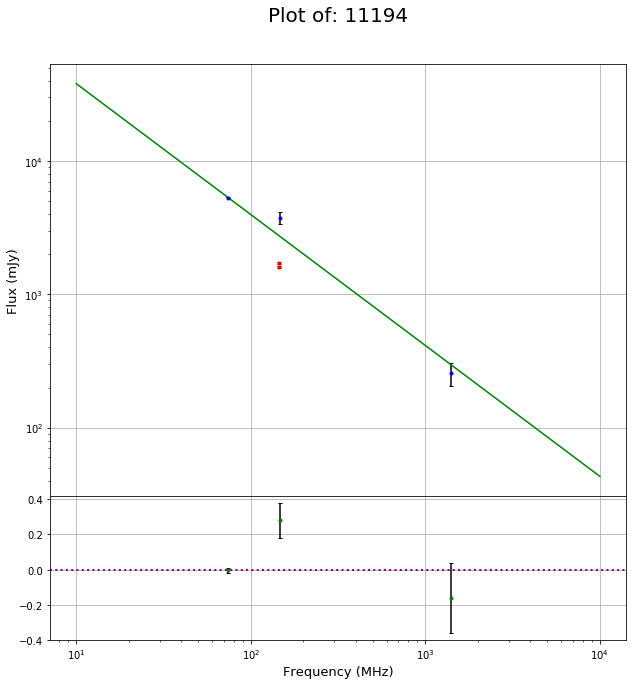

[ 325.   365.   151.  1400.    74.   151.   147.5   74. ]
with a goodness of fit of: 0.531 and a dof of: 6.0


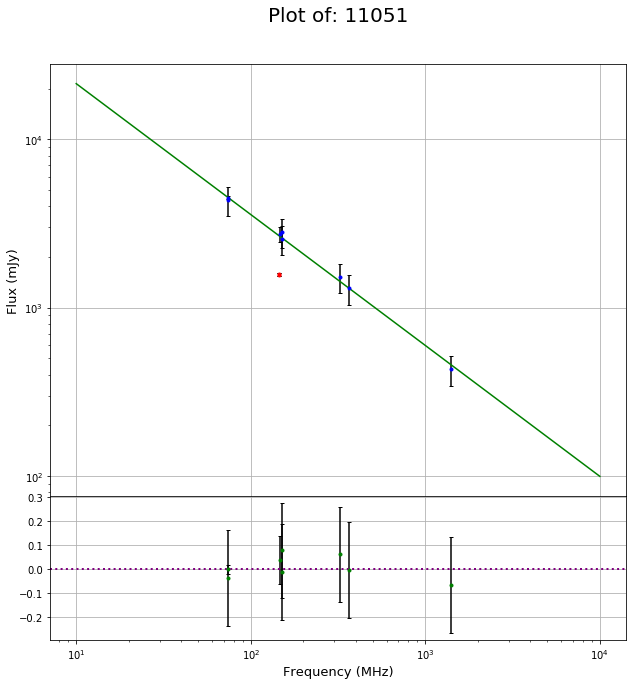

[ 151.   325.  1400.  4850.  4850.   147.5   74. ]
with a goodness of fit of: 2.233 and a dof of: 5.0


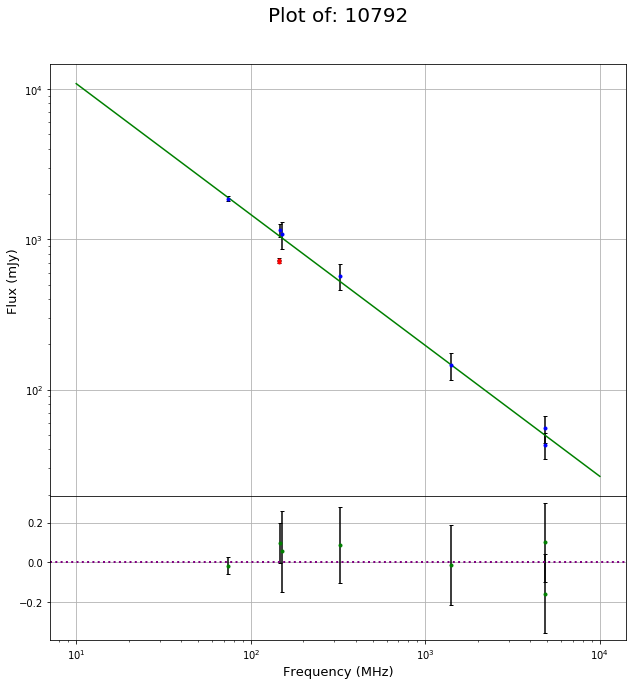

[ 325.  1400.  1400.   365.   151.   151.   147.5   74. ]
with a goodness of fit of: 1.194 and a dof of: 6.0


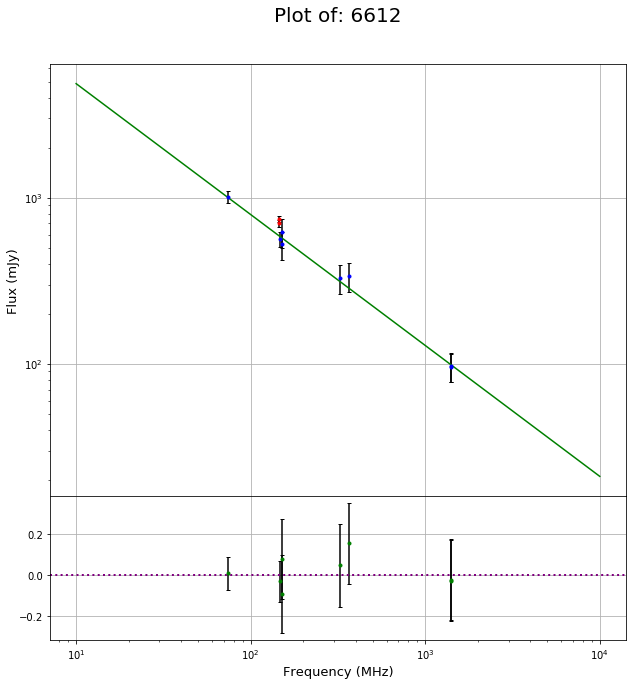

[365.  74.]
with a goodness of fit of: 25.000 and a dof of: 0.0


/home/kmeulen/virtualenv/local/lib/python2.7/site-packages/scipy/optimize/minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


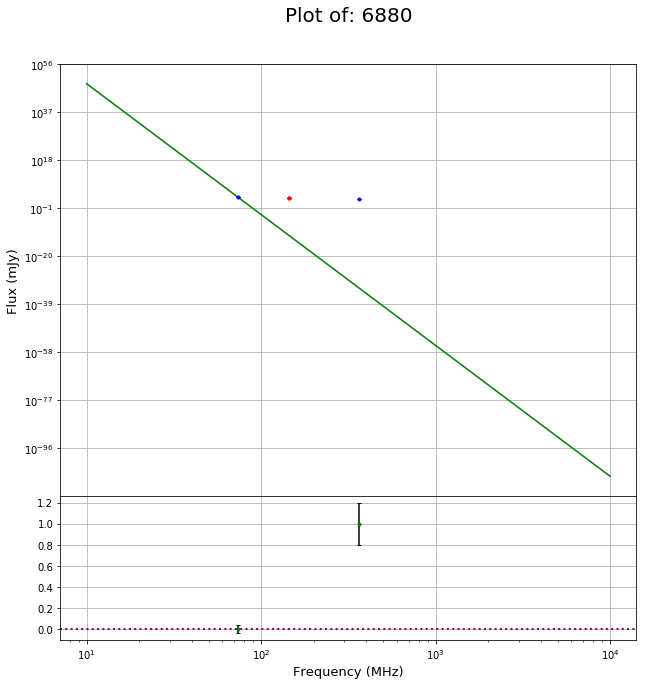

[ 365. 4885. 8400.  325. 1400. 1400.  151.  151.   74.]
with a goodness of fit of: 15.837 and a dof of: 7.0


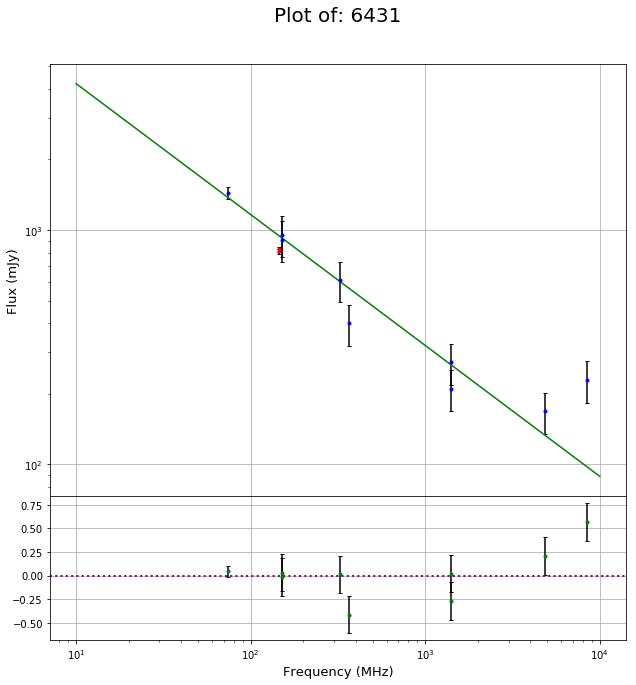

[1400.  1400.   325.    74.   147.5]
with a goodness of fit of: 1.309 and a dof of: 3.0


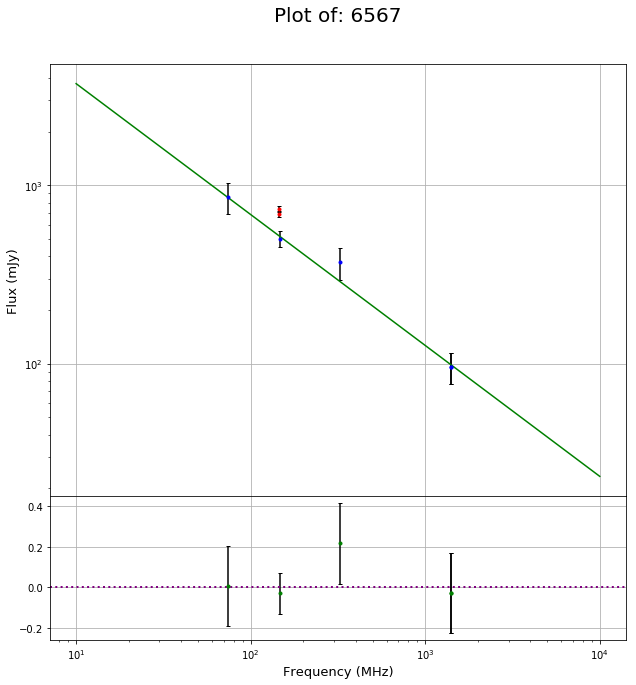

[1400.  151.  325.  365. 1400.  151.   74.]
with a goodness of fit of: 2.586 and a dof of: 5.0


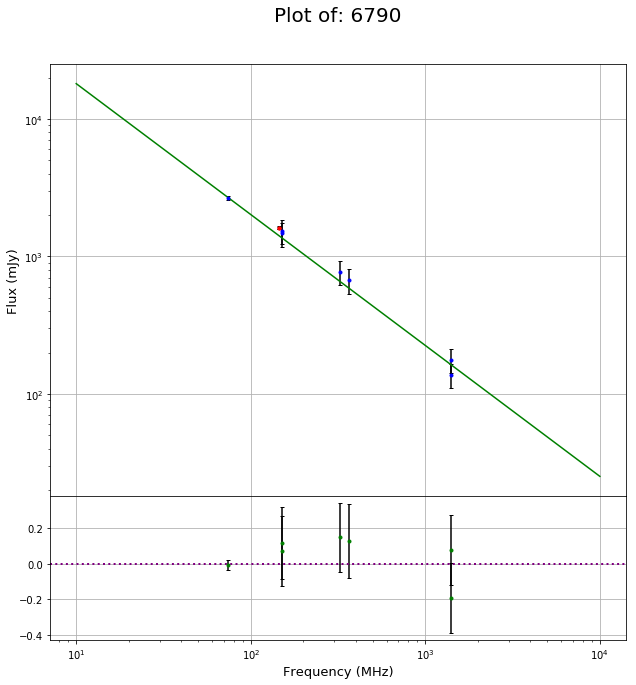

[8400.   325.  1400.  8400.  1400.   151.   147.5]
with a goodness of fit of: 3.240 and a dof of: 5.0


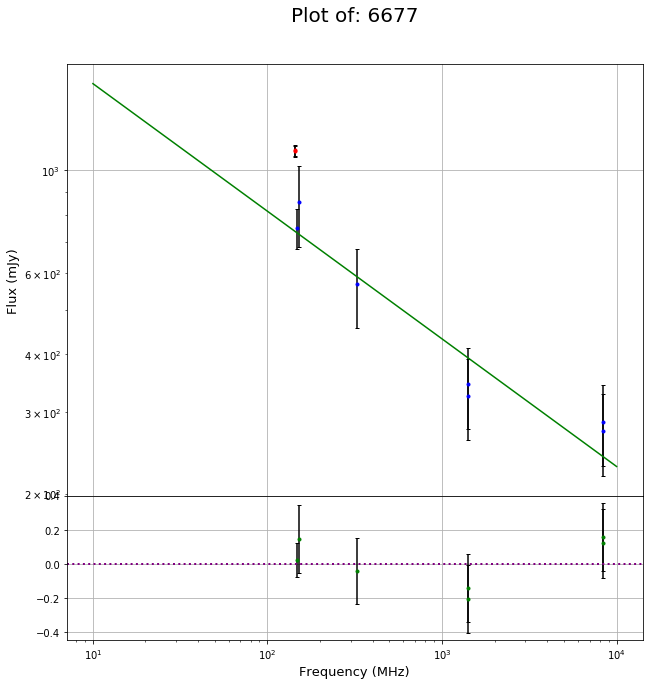

[ 325. 4850.  151. 4850. 1400.  365.   74.]
with a goodness of fit of: 2.532 and a dof of: 5.0


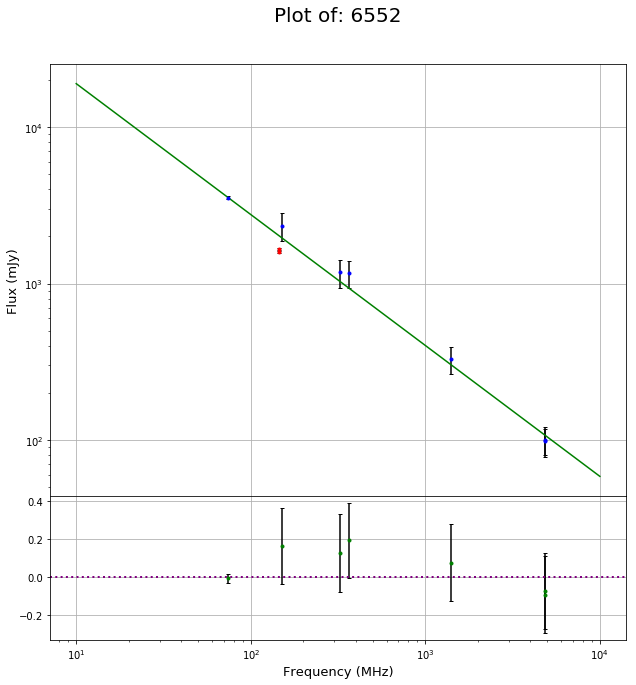

[1400. 1400.  325.  365.  151.   74.   74.]
with a goodness of fit of: 0.939 and a dof of: 5.0


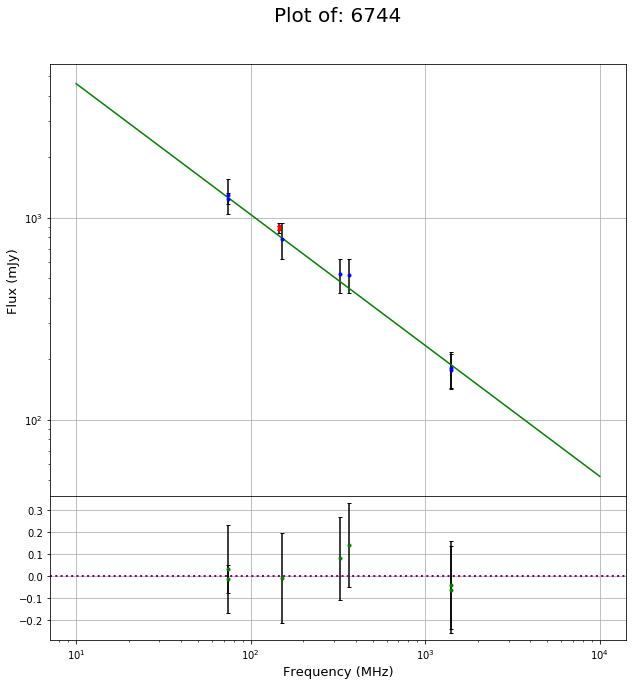

[ 151.  365.  151.  325. 1400. 1400.   74.   74.]
with a goodness of fit of: 1.248 and a dof of: 6.0


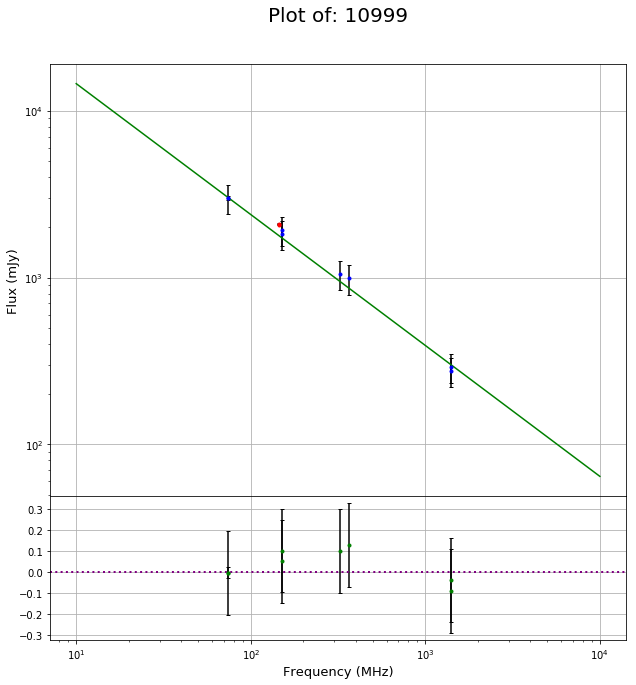

[ 365.  151. 1400. 1400.  325.  151.   74.]
with a goodness of fit of: 2.623 and a dof of: 5.0


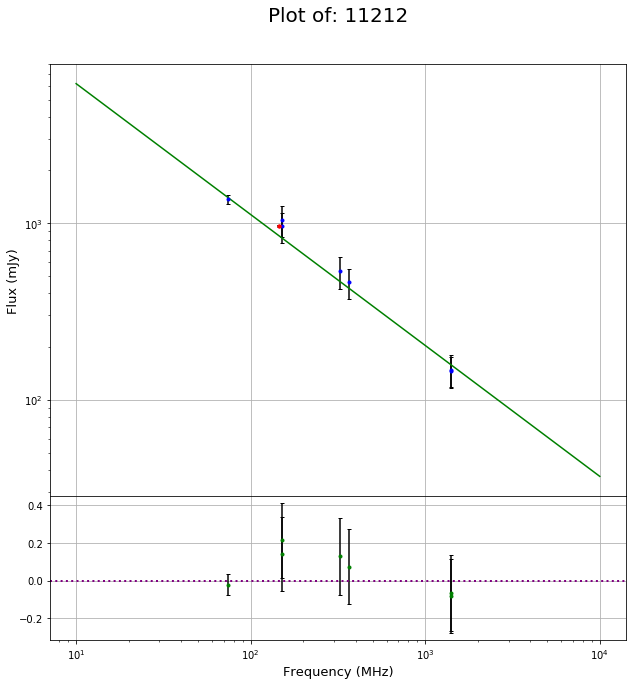

[8400.  8400.   325.   365.  1400.   151.   151.   147.5]
with a goodness of fit of: 6.264 and a dof of: 6.0


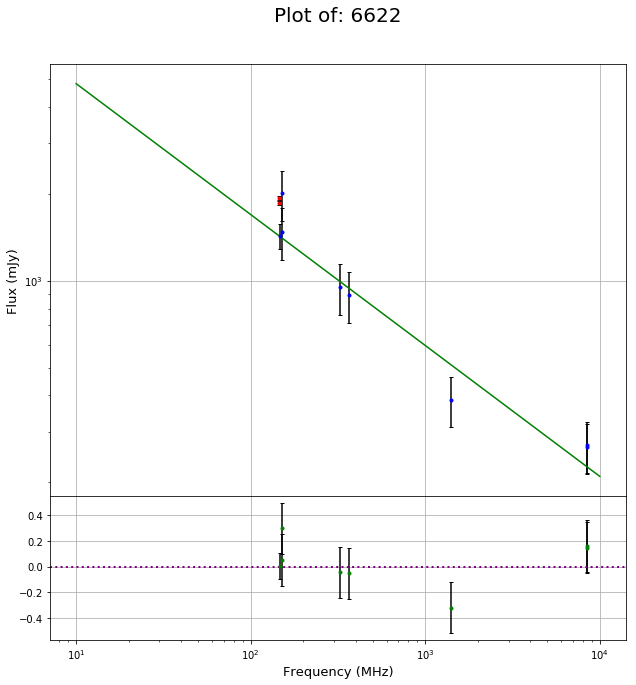

[ 151. 1400.  325. 1400.  365. 4850.   74.]
with a goodness of fit of: 10.862 and a dof of: 5.0


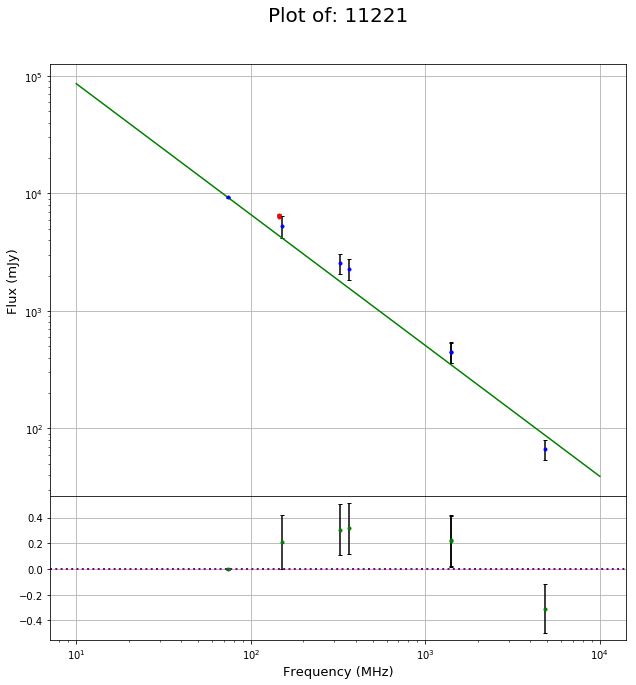

[365. 151.  74.  74.]
with a goodness of fit of: 1.723 and a dof of: 2.0


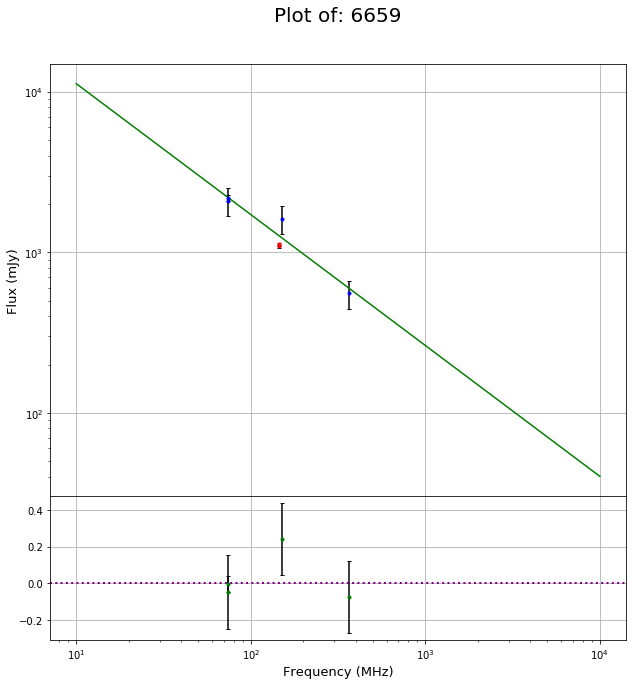

[ 325. 1400.  151.   74.]
with a goodness of fit of: 0.262 and a dof of: 2.0


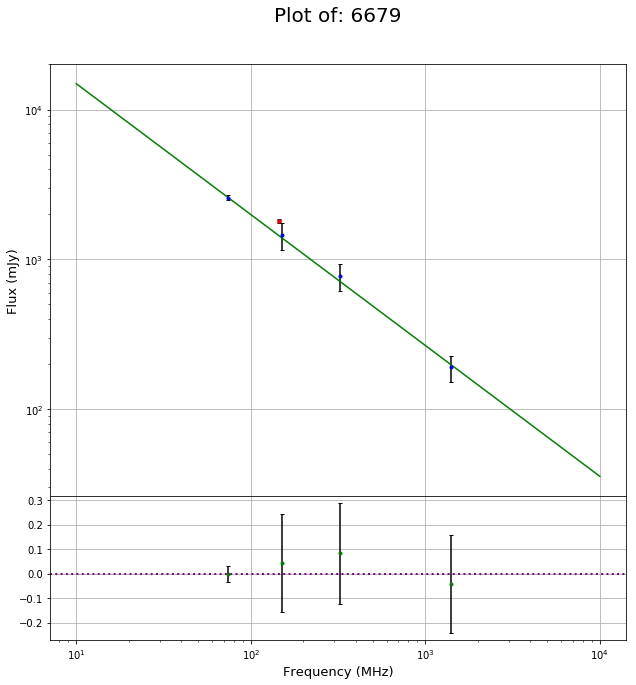

[ 365.  151.  325. 1400. 1400.  408.   74.   74.]
with a goodness of fit of: 1.668 and a dof of: 6.0


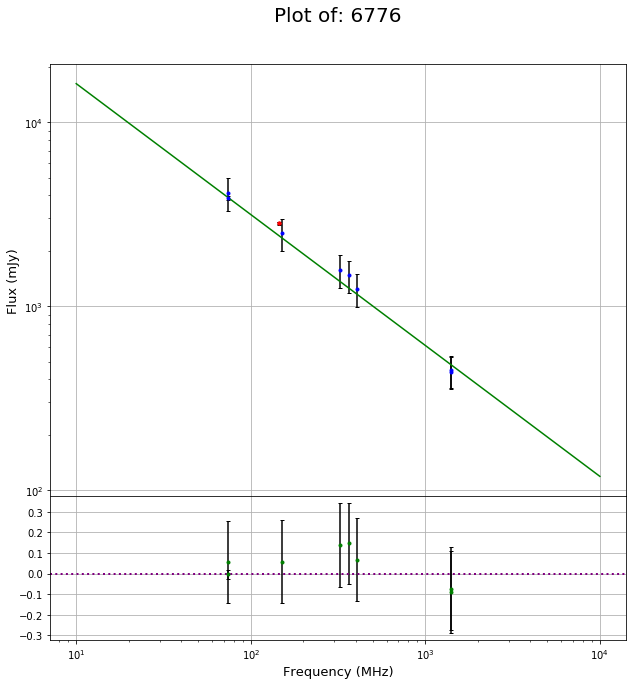

[1400.  325.  365. 1400.   74.]
with a goodness of fit of: 1.317 and a dof of: 3.0


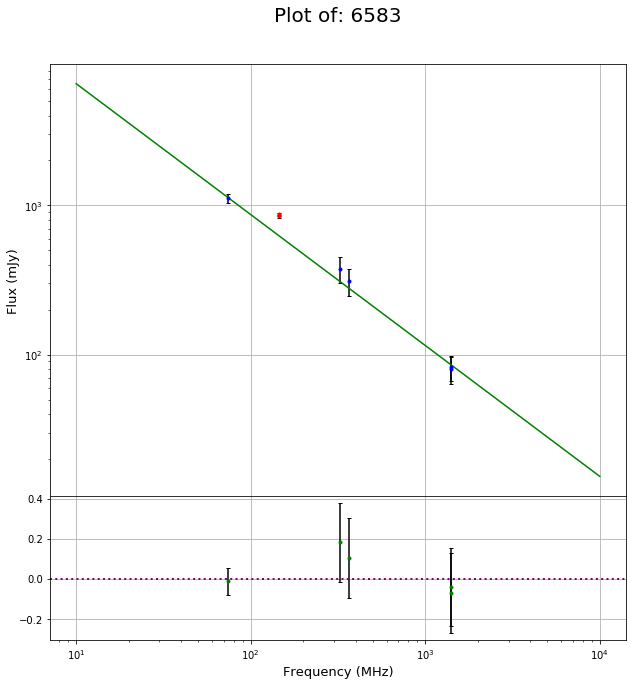

[ 365. 1400.  325. 1400.  151.  151.   74.]
with a goodness of fit of: 2.715 and a dof of: 5.0


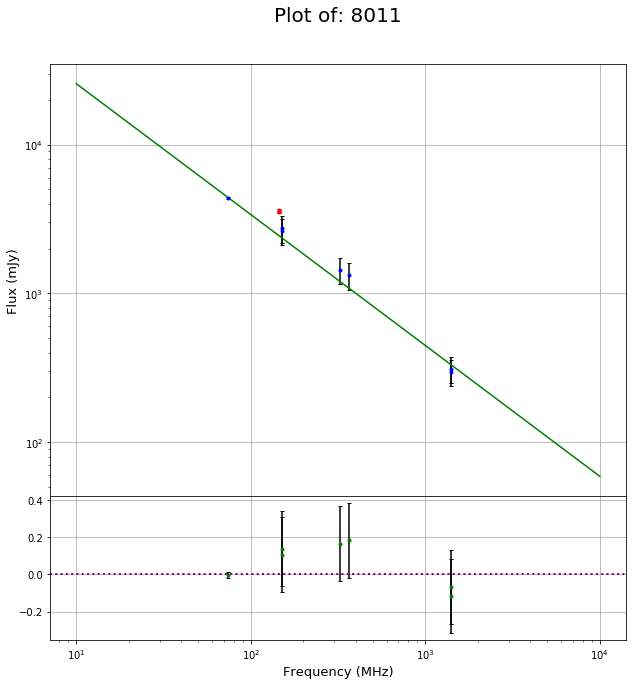

[1400. 4850.   74.   74.]
with a goodness of fit of: 50.004 and a dof of: 2.0


/home/kmeulen/virtualenv/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in power
  import sys
/home/kmeulen/virtualenv/local/lib/python2.7/site-packages/numpy/ma/core.py:6649: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


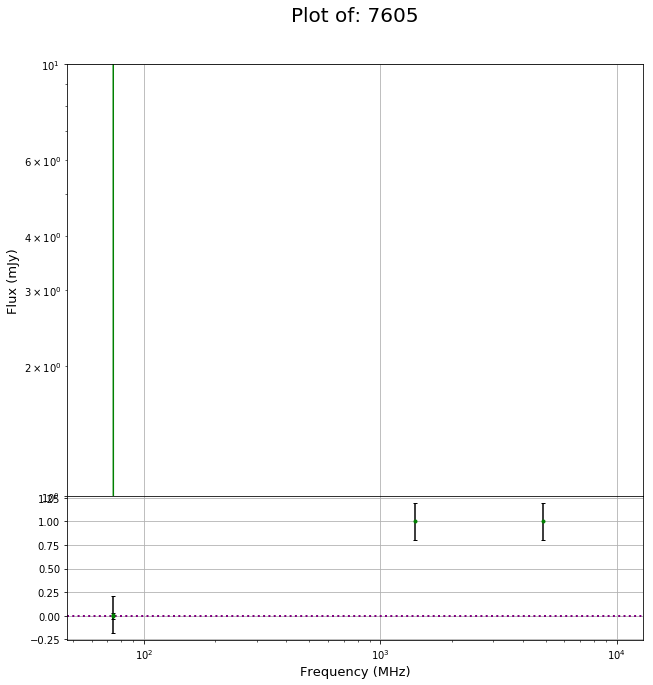

[8400. 1400.  151. 8400. 8400.  325.  365. 1465. 4885. 1400.  151.   74.]
with a goodness of fit of: 6.378 and a dof of: 10.0


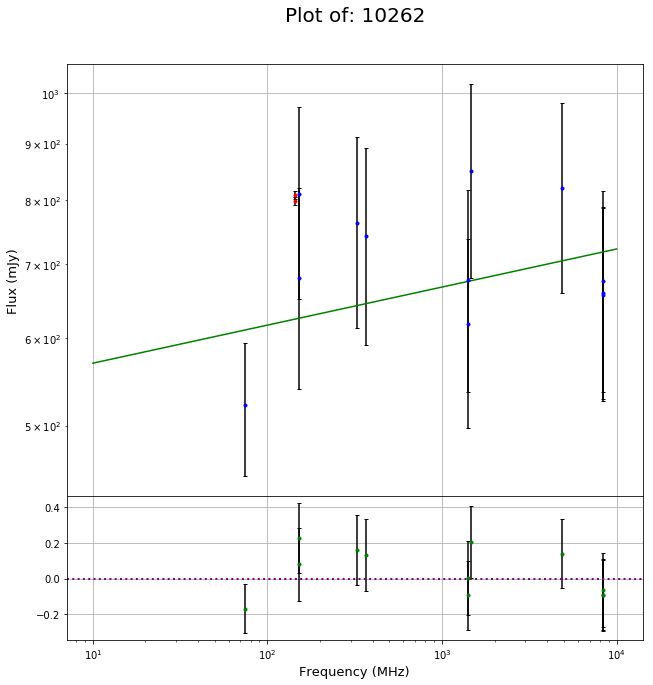

[1400.  325.  365.   74.  151.   74.]
with a goodness of fit of: 1.579 and a dof of: 4.0


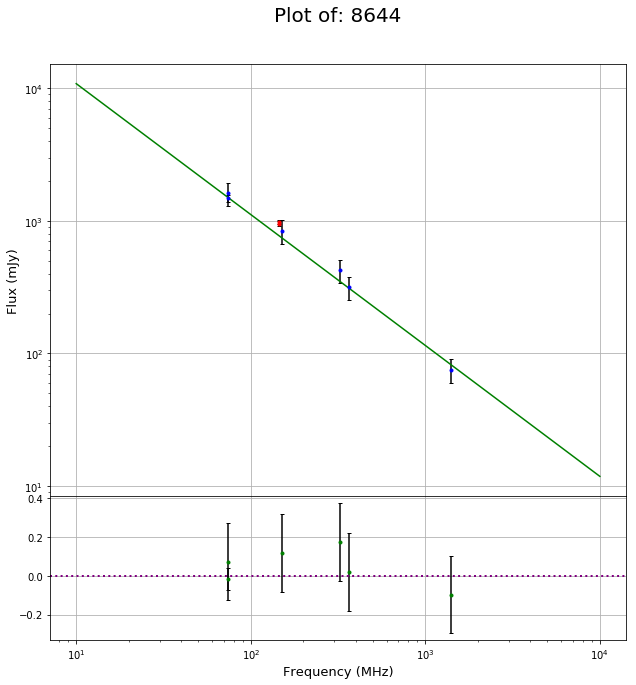

[ 325.  151. 1400.  365.   74.   74.]
with a goodness of fit of: 3.013 and a dof of: 4.0


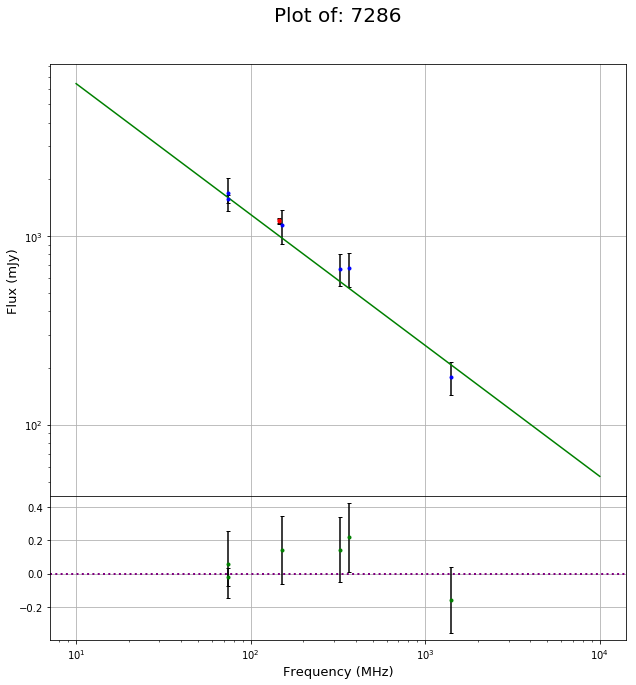

[1400.  365. 4850.   74.]
with a goodness of fit of: 2.605 and a dof of: 2.0


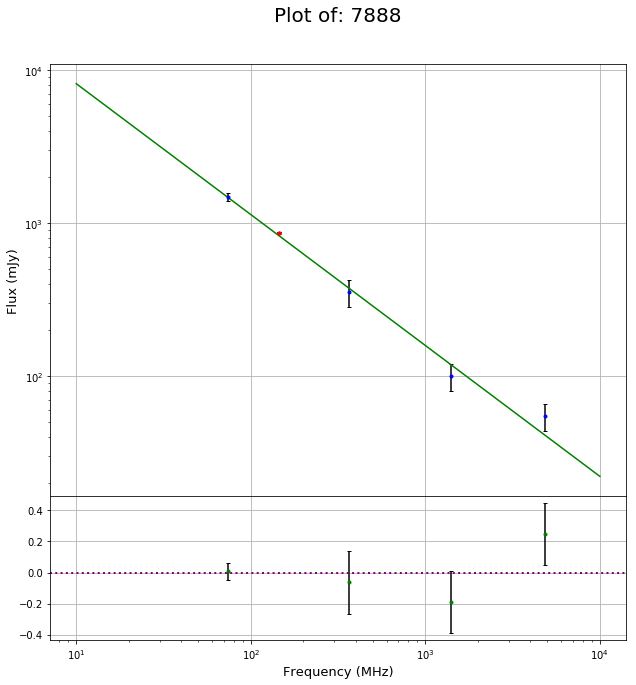

[ 151. 1400.  325. 1400.  365. 4885.   74.   74.]
with a goodness of fit of: 1.389 and a dof of: 6.0


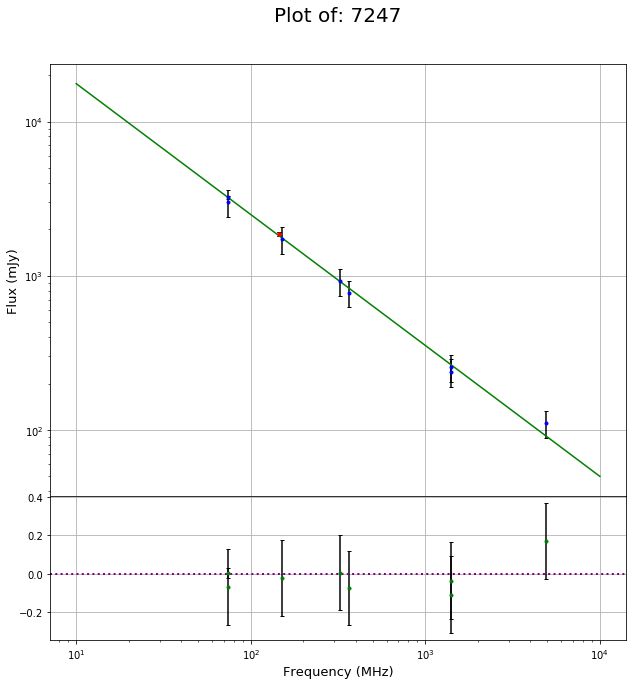

[1400.  325.  365.  151.   74.]
with a goodness of fit of: 1.242 and a dof of: 3.0


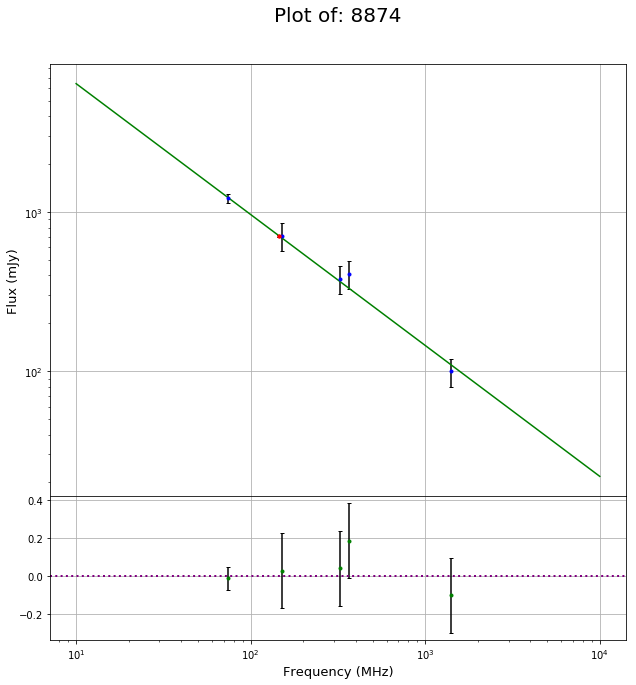

[1400.  151. 1400.  325.   74.   74.]
with a goodness of fit of: 2.761 and a dof of: 4.0


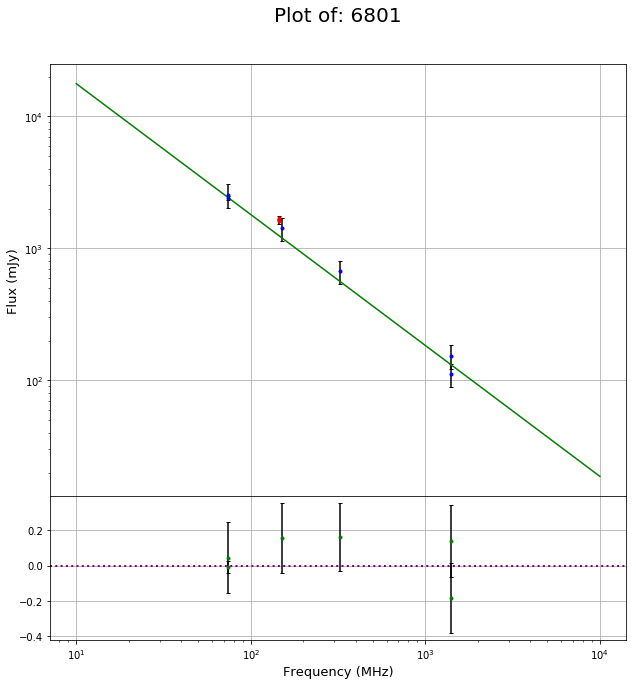

[ 151.  325. 1400. 1400.   74.   74.]
with a goodness of fit of: 2.662 and a dof of: 4.0


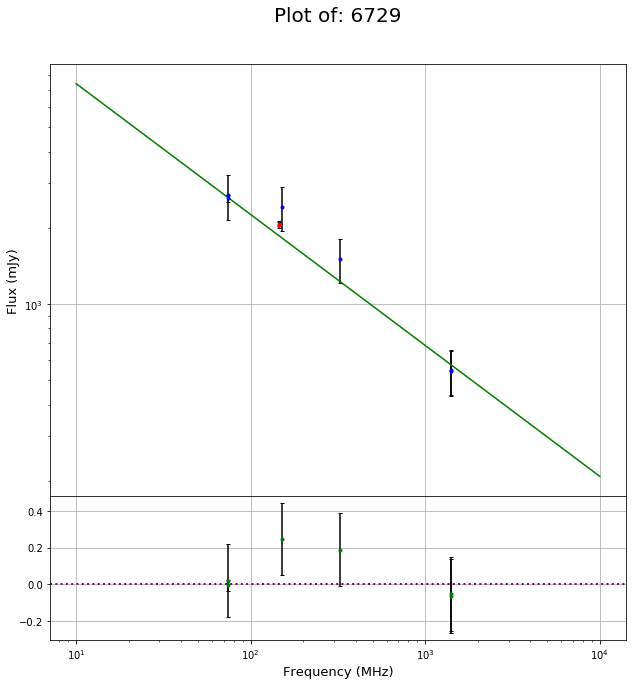

In [34]:

# initialize x
x = np.arange(1e1, 1e4, 1)

# loops through the data gathered sorting by id and plotting the fit
for i in dfFlux.id.unique():
    specid = dfFlux[dfFlux.id == i]
    ids = int(i)
    freq = np.array(specid.nu.astype(float))
    flux = np.array(specid.s_nu.astype(float))
    fluxerr = np.array(specid.e.astype(float))
    
    
#     Append catalogue data to the set:
    for j in FluxVar.instances:
        if j.id == ids:
            freq = np.append(freq,j.database.freq)
            flux = np.append(flux,j.database.pflux[j.entry]*10**3 )
            fluxerr = np.append(fluxerr,j.database.pfluxe[j.entry]*10**3 )

    print freq
    
    #Initialize figure
    fig1 = plt.figure(1,figsize=(10,10))
    fig1.suptitle("Plot of: " + str(ids),fontsize=20)
    
    #add first frame
    frame1=fig1.add_axes((.1,.3,.8,.6))
    matplotlibfunction(frame1,freq,flux,fluxerr,"blue")
    

    
    try:
        fit,chisquare,dof,ml_cfpars, ml_cfcovar = fitexistingdata(freq,flux,fluxerr,ids,x)

    except:
        print "for id: %i there is no good fit" %ids
        print freq

    
    try:
        print "with a goodness of fit of: %0.3f and a dof of: %0.1f" %(chisquare,dof)
    except:
        pass
    
    getSourceData2(frame1,int(ids),colour = 'red')
    
#   initialize normal frame
    frame1.set_xscale('log')
    frame1.set_yscale('log')
    frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
    frame1.set_ylabel("Flux (mJy)",fontsize = 13)
    plt.plot(x,fit,color='green')
    plt.grid()
    
#   initialize residual frame
    frame2=fig1.add_axes((.1,.1,.8,.2),sharex = frame1) 
    matplotlibfunction(frame2,freq,(flux-starmodel2(freq,*ml_cfpars))/flux,fluxerr/flux,'green')
    plt.axhline(0.0, color='purple', linestyle='dotted', lw=2)
    frame2.set_xscale('log')
    frame2.set_xlabel('Frequency (MHz)',fontsize=13)
    plt.grid()
    if savefigs:
        try:
            homedir = os.getcwd()
            newdir = homedir+"/" +timescale+ technique
            os.mkdir(newdir)
            os.chdir(newdir)
            plt.savefig(timescale + str(ids) +".png" )
            os.chdir(homedir)
        except:
            os.chdir(newdir)
            plt.savefig(timescale + str(ids) +".png" )
            os.chdir(homedir)
    plt.show() 
    


# Do not add tgss or vlssr data to the fit for this singular source where shit hits the fan

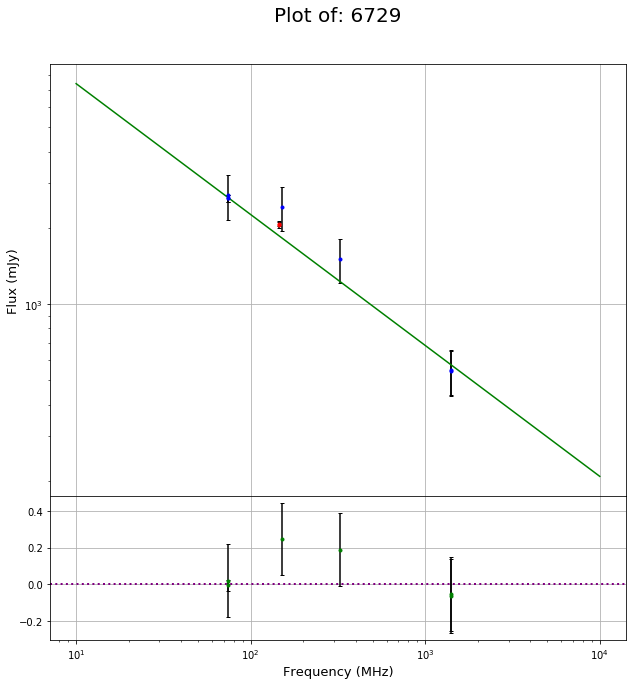

__________________________________________________________________________________________


In [35]:
for i in dfFlux.id.unique():
    if i == "2004":
        specid = dfFlux[dfFlux.id == i]
        ids = int(i)
        freq = np.array(specid.nu.astype(float))
        flux = np.array(specid.s_nu.astype(float))
        fluxerr = np.array(specid.e.astype(float))
        ids = int(i)

# Initialize figure
fig1 = plt.figure(1,figsize=(10,10))
fig1.suptitle("Plot of: " + str(ids),fontsize=20)

#add frame1
frame1=fig1.add_axes((.1,.3,.8,.6))
matplotlibfunction(frame1,freq,flux,fluxerr,"blue")


# initialize x
x = np.arange(1e1, 1e4, 1)
try:
    fit,chisquare,dof,ml_cfpars, ml_cfcovar = fitexistingdata(freq,flux,fluxerr,ids,x)

except:
    print "for id: %i there is no good fit" %ids
    print freq
    
    
    

for j in FluxVar.instances:
    if j.id == ids:

        matplotlibfunction(frame1,j.database.freq,j.database.pflux[j.entry]*10**3,j.database.pfluxe[j.entry]*10**3,colour='blue')



getSourceData2(frame1,int(ids),colour = 'red')

# Initialize normal frame
frame1.set_xscale('log')
frame1.set_yscale('log')
frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
frame1.set_ylabel("Flux (mJy)",fontsize = 13)
plt.plot(x,fit,color='green')
plt.grid()

# initialize residuals frame
frame2=fig1.add_axes((.1,.1,.8,.2),sharex = frame1) 
matplotlibfunction(frame2,freq,(flux-starmodel2(freq,*ml_cfpars))/flux,fluxerr/flux,'green')
plt.axhline(0.0, color='purple', linestyle='dotted', lw=2)
frame2.set_xscale('log')
frame2.set_xlabel('Frequency (MHz)',fontsize=13)
plt.grid()

# if we wanna save we save
if savefigs:
    os.chdir(newdir)
    plt.savefig(timescale + str(ids) +".png" )
    os.chdir(homedir)
plt.show()
# make figure for and get the residuals

# p = figure(title="residuals", x_axis_label='freq (MHz)', y_axis_label='flux(mJy)',x_axis_type='log')


# p = bokehplotfunction(p,freq,(flux-starmodel2(freq,*ml_cfpars))/flux,fluxerr/flux,'green')
# p.line(x,0,color='purple',line_dash='dashed')

# show(p)
print "__________________________________________________________________________________________"

# Make Reg.file for quick comparison in original data

In [36]:
try:
    os.chdir(newdir)
except:
    homedir = os.getcwd()
    newdir = homedir+"/" +timescale+ technique
    os.chdir(newdir)

wr.WriteReg(timescale,PosVar.instances,FluxVar.instances)
os.chdir(homedir)

# TEST MAKE IMAGES FOR TGSS

In [37]:
jsonwriter.WriteFluxJson(PosVar.instances,pos=True)

In [38]:
jsonFile = open("tgpos.json","r")
datalistjson = json.load(jsonFile)
n = len(datalistjson)
jsonFile.close()
try:
    os.remove('poslink.json')
except:
    print 'allready removed'
for i in range(n):
    !{sys.executable} -m scrapy runspider databasescrapper.py -o poslink.json






allready removed
/home/kmeulen/virtualenv/local/lib/python2.7/site-packages/cryptography/hazmat/primitives/constant_time.py:26: CryptographyDeprecationWarning: Support for your Python version is deprecated. The next version of cryptography will remove support. Please upgrade to a 2.7.x release that supports hmac.compare_digest as soon as possible.
  utils.DeprecatedIn23,
2018-10-12 16:37:02 [scrapy.utils.log] INFO: Scrapy 1.5.1 started (bot: scrapybot)
2018-10-12 16:37:02 [scrapy.utils.log] INFO: Versions: lxml 4.2.5.0, libxml2 2.9.8, cssselect 1.0.3, parsel 1.5.0, w3lib 1.19.0, Twisted 18.7.0, Python 2.7.6 (default, Nov 23 2017, 15:49:48) - [GCC 4.8.4], pyOpenSSL 18.0.0 (OpenSSL 1.1.0i  14 Aug 2018), cryptography 2.3.1, Platform Linux-3.13.0-141-generic-x86_64-with-Ubuntu-14.04-trusty
2018-10-12 16:37:02 [scrapy.crawler] INFO: Overridden settings: {'SPIDER_LOADER_WARN_ONLY': True, 'FEED_FORMAT': 'json', 'FEED_URI': 'poslink.json'}
2018-10-12 16:37:02 [scrapy.middleware] INFO: Enabled 

/home/kmeulen/virtualenv/local/lib/python2.7/site-packages/cryptography/hazmat/primitives/constant_time.py:26: CryptographyDeprecationWarning: Support for your Python version is deprecated. The next version of cryptography will remove support. Please upgrade to a 2.7.x release that supports hmac.compare_digest as soon as possible.
  utils.DeprecatedIn23,
2018-10-12 16:37:05 [scrapy.utils.log] INFO: Scrapy 1.5.1 started (bot: scrapybot)
2018-10-12 16:37:05 [scrapy.utils.log] INFO: Versions: lxml 4.2.5.0, libxml2 2.9.8, cssselect 1.0.3, parsel 1.5.0, w3lib 1.19.0, Twisted 18.7.0, Python 2.7.6 (default, Nov 23 2017, 15:49:48) - [GCC 4.8.4], pyOpenSSL 18.0.0 (OpenSSL 1.1.0i  14 Aug 2018), cryptography 2.3.1, Platform Linux-3.13.0-141-generic-x86_64-with-Ubuntu-14.04-trusty
2018-10-12 16:37:05 [scrapy.crawler] INFO: Overridden settings: {'SPIDER_LOADER_WARN_ONLY': True, 'FEED_FORMAT': 'json', 'FEED_URI': 'poslink.json'}
2018-10-12 16:37:05 [scrapy.middleware] INFO: Enabled extensions:
['scr

/home/kmeulen/virtualenv/local/lib/python2.7/site-packages/cryptography/hazmat/primitives/constant_time.py:26: CryptographyDeprecationWarning: Support for your Python version is deprecated. The next version of cryptography will remove support. Please upgrade to a 2.7.x release that supports hmac.compare_digest as soon as possible.
  utils.DeprecatedIn23,
2018-10-12 16:37:07 [scrapy.utils.log] INFO: Scrapy 1.5.1 started (bot: scrapybot)
2018-10-12 16:37:07 [scrapy.utils.log] INFO: Versions: lxml 4.2.5.0, libxml2 2.9.8, cssselect 1.0.3, parsel 1.5.0, w3lib 1.19.0, Twisted 18.7.0, Python 2.7.6 (default, Nov 23 2017, 15:49:48) - [GCC 4.8.4], pyOpenSSL 18.0.0 (OpenSSL 1.1.0i  14 Aug 2018), cryptography 2.3.1, Platform Linux-3.13.0-141-generic-x86_64-with-Ubuntu-14.04-trusty
2018-10-12 16:37:07 [scrapy.crawler] INFO: Overridden settings: {'SPIDER_LOADER_WARN_ONLY': True, 'FEED_FORMAT': 'json', 'FEED_URI': 'poslink.json'}
2018-10-12 16:37:07 [scrapy.middleware] INFO: Enabled extensions:
['scr

## Download tgss fits images

In [39]:
os.chdir(homedir)
try:
    os.rename(homedir+"/poslink.json", newdir+"/poslink.json")
except:
    pass
try:
    os.rename(homedir+"/downloader.py", newdir+"/downloader.py")
except:
    pass


os.chdir(newdir)
!{sys.executable} downloader.py

try:
    os.rename(newdir+"/downloader.py", homedir+"/downloader.py")
except:
    pass

os.chdir(homedir)



{u'url': u'https://vo.astron.nl/getproduct/tgssadr/fits/TGSSADR_R37D63_5x5.MOSAIC.FITS?sdec=0.5\\&dec=50.4790\\&ra=-176.4753\\&sra=0.702221502732', u'id': u'15972', u'name': u'tgss'}
--2018-10-12 16:37:08--  https://vo.astron.nl/getproduct/tgssadr/fits/TGSSADR_R37D63_5x5.MOSAIC.FITS?sdec=0.5&dec=50.4790&ra=-176.4753&sra=0.702221502732
Resolving vo.astron.nl (vo.astron.nl)... 192.87.1.9
Connecting to vo.astron.nl (vo.astron.nl)|192.87.1.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/fits]
Saving to: '15972tgss.fits'

    [ <=>                                   ] 305,280     --.-K/s   in 0.03s   

2018-10-12 16:37:08 (11.0 MB/s) - '15972tgss.fits' saved [305280]

{u'url': u'https://vo.astron.nl/getproduct/tgssadr/fits/TGSSADR_R38D60_5x5.MOSAIC.FITS?sdec=0.5\\&dec=44.9394\\&ra=-173.5243\\&sra=0.702221502732', u'id': u'16130', u'name': u'tgss'}
--2018-10-12 16:37:08--  https://vo.astron.nl/getproduct/tgssadr/fits/TGSSADR_R38D60_5x5.MOSAIC.FIT

## Convert fits to png

16216tgss.fits
Filename: 16216tgss.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      62   (255, 302, 1, 1)   float32   


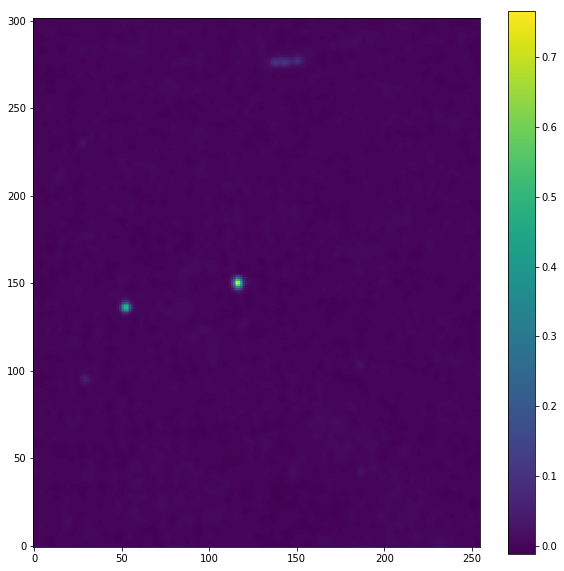

16326tgss.fits
Filename: 16326tgss.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      60   (232, 303, 1, 1)   float32   


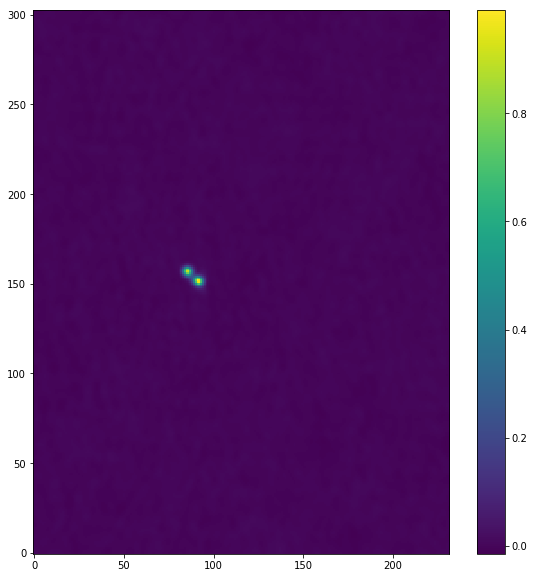

16130tgss.fits
Filename: 16130tgss.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      62   (294, 287, 1, 1)   float32   


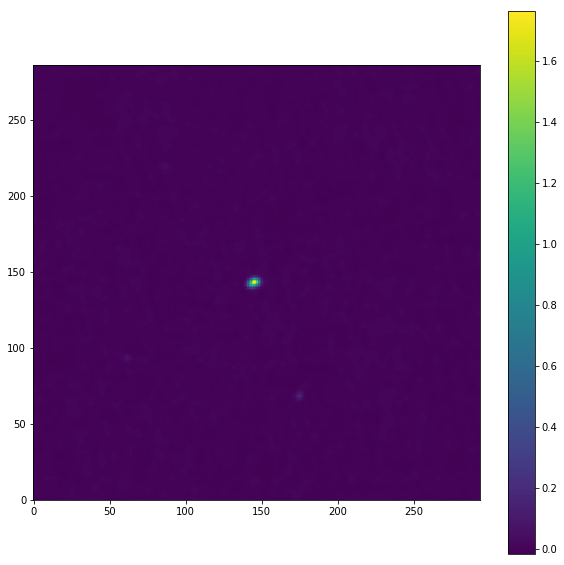

16306tgss.fits
Filename: 16306tgss.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      62   (252, 299, 1, 1)   float32   


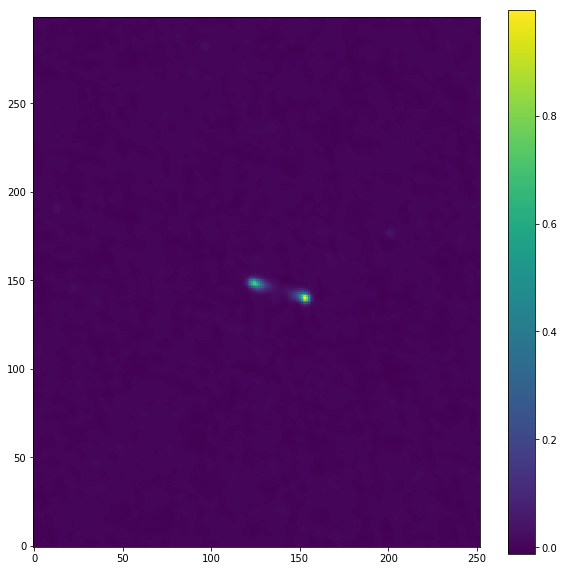

15972tgss.fits
Filename: 15972tgss.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      60   (246, 303, 1, 1)   float32   


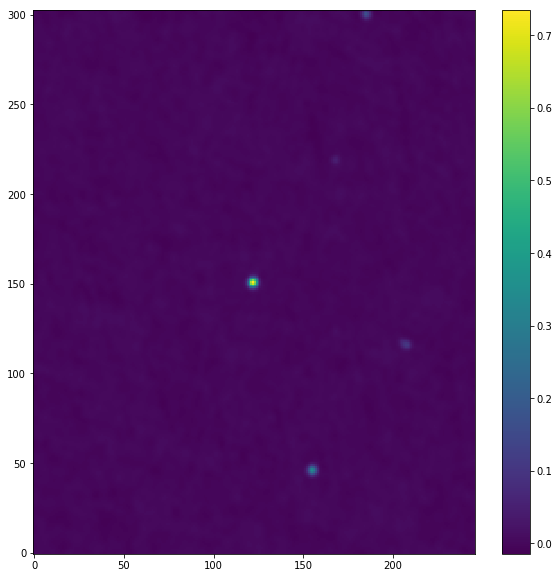

In [40]:

os.chdir(newdir)
imagez = glob.glob('*.fits')
for i in imagez:
    print i
    rpf.Imager(i)

# Make cutouts of own dataset

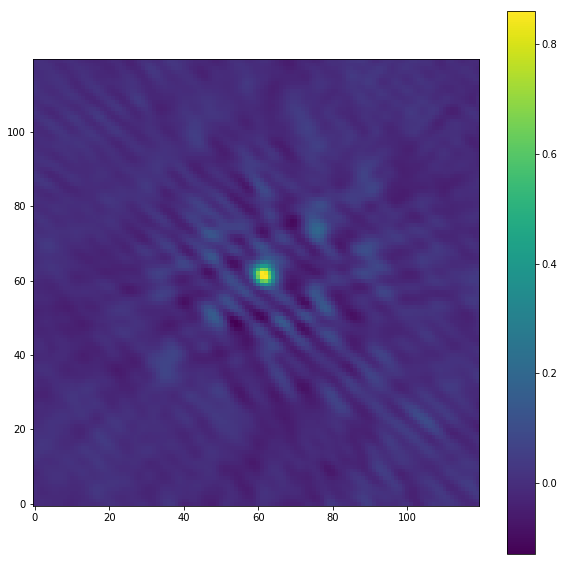

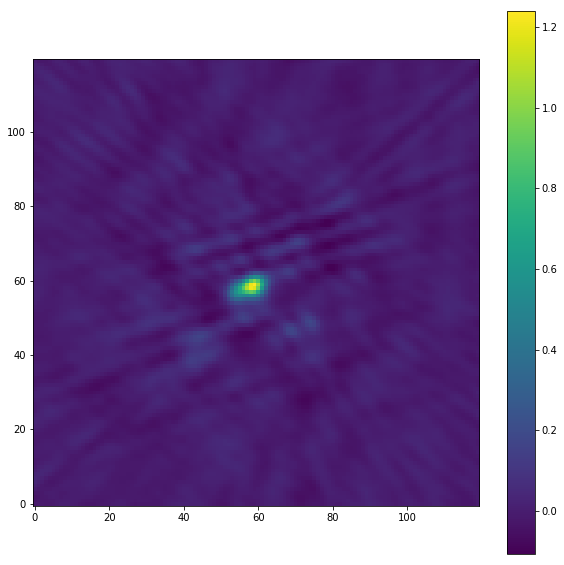

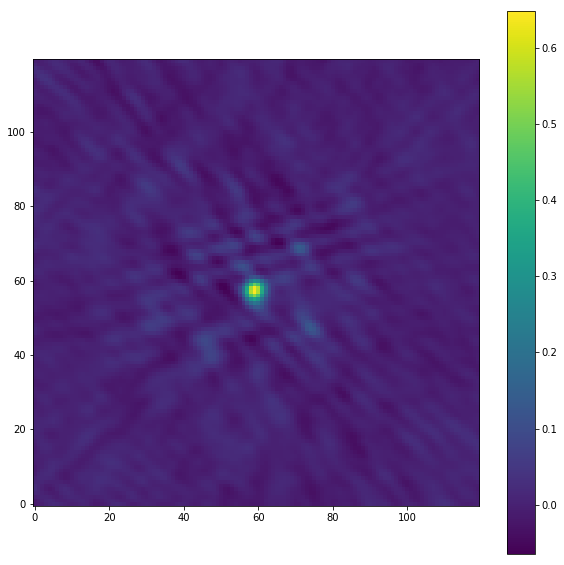

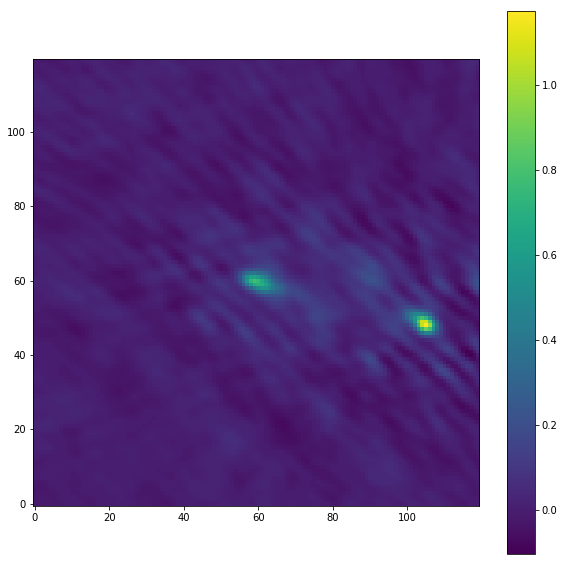

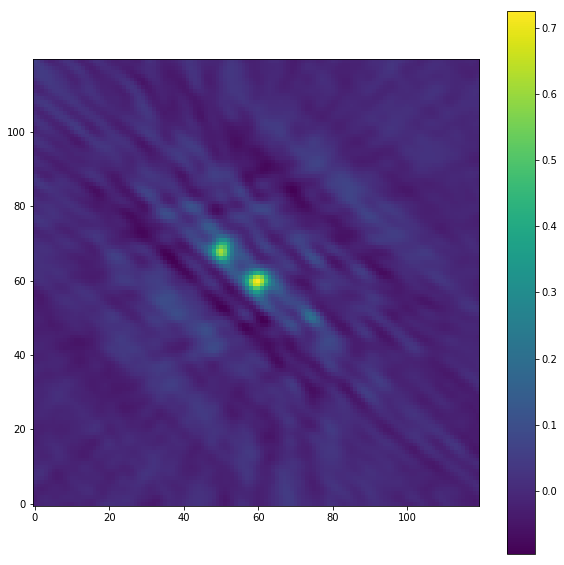

In [46]:
os.chdir(homedir)
os.chdir(newdir)
for i in PosVar.instances:
    if i.dataname == 'tgss':
        try:
            ct.GetCutout(i.url[0],i.ra,i.dec,i.id)
        except:
            print i.ra
            print 'failure'


# plot in Latex

In [42]:
print "\\begin{longtable}{c|c|c|c} \n\
\\toprule \nId & Data & TGSS (deg)& VLSSR  \\\\\\midrule \n\\endfirsthead \n\\toprule \
\nId & Data & TGSS (deg)& VLSSR   \\\\\\midrule \n\\endhead \n\\bottomrule \n\\endfoot \n\\bottomrule"

# define caption for table
print "\\caption{ Comparison position of candidates with different databases for the 1hr interval data} \n\\endlastfoot"

for i in samesieslist:
    a = "\\raisebox{-\\totalheight}{\\includegraphics[width=6cm, height=6cm]{"+str(i[0])+"cutout.png}}"+" & "
    if i[1] == "tgss":
        b = ("\\raisebox{-\\totalheight}{\\includegraphics[width=6cm, height=6cm]{"+str(i[0])+"tgss.png}}"+" & - \\\\")
    if i[1] =="vlssr":
        b = ("- & \\raisebox{-\\totalheight}{\\includegraphics[width=6cm, height=6cm]{"+str(i[0])+"vlssr.png}} \\\\")
    if i[1] == "tgss \\& vlssr":
        b = ("\\raisebox{-\\totalheight}{\\includegraphics[width=6cm, height=6cm]{"+str(i[0])+"tgss.png}}"+" "+ "&"\
                + " "+ "\\raisebox{-\\totalheight}{\\includegraphics[width=6cm, height=6cm]{"+str(i[0])+"vlssr.png}} \\\\")
    print str(i[0])+" "+ "&"+ " "+ a + b

print "\\end{longtable}"

# print len(printstoreidlist)
# for i in printstoreidlist:
#     print i
#     if i in b[:,1]:
#         print 'succes'

# # print a
# # print b
#     print str(i.id) +" "+ "&"+ " "+
# lastname = None
# for i in samesieslist:
#     if i[1] != lastname and lastname:
#         print "\\hline"
#     print i[1] +" "+ "&"+ " "+ '%0.3f' %i[2].ra + " " + "&"+ " "+ "%0.3f" %(i[2].dec) +\
#     " " + "&" + " " +i[2].fk5 +" " + '&' + "  "+ latexHREF +str(i[0])+"}" + "{%i}" %i[0] +" " + '&' + "  "+"\\" + "\\"
    
#     lastname = i[1]

# print "\\end{longtable}"

\begin{longtable}{c|c|c|c} 
\toprule 
Id & Data & TGSS (deg)& VLSSR  \\\midrule 
\endfirsthead 
\toprule 
Id & Data & TGSS (deg)& VLSSR   \\\midrule 
\endhead 
\bottomrule 
\endfoot 
\bottomrule
\caption{ Comparison position of candidates with different databases for the 1hr interval data} 
\endlastfoot
15972 & \raisebox{-\totalheight}{\includegraphics[width=6cm, height=6cm]{15972cutout.png}} & \raisebox{-\totalheight}{\includegraphics[width=6cm, height=6cm]{15972tgss.png}} & \raisebox{-\totalheight}{\includegraphics[width=6cm, height=6cm]{15972vlssr.png}} \\
16130 & \raisebox{-\totalheight}{\includegraphics[width=6cm, height=6cm]{16130cutout.png}} & \raisebox{-\totalheight}{\includegraphics[width=6cm, height=6cm]{16130tgss.png}} & \raisebox{-\totalheight}{\includegraphics[width=6cm, height=6cm]{16130vlssr.png}} \\
16216 & \raisebox{-\totalheight}{\includegraphics[width=6cm, height=6cm]{16216cutout.png}} & \raisebox{-\totalheight}{\includegraphics[width=6cm, height=6cm]{16216tgss.png}}

In [43]:
for i in samesieslist:
    print i

[15972, 'tgss \\& vlssr', <__main__.PosVar object at 0x7f1aa5392290>]
[16130, 'tgss \\& vlssr', <__main__.PosVar object at 0x7f1ade5d1dd0>]
[16216, 'tgss \\& vlssr', <__main__.PosVar object at 0x7f1ade5d1750>]
[16306, 'tgss \\& vlssr', <__main__.PosVar object at 0x7f1ade5d1c50>]
[16326, 'tgss \\& vlssr', <__main__.PosVar object at 0x7f1ade5d1410>]


In [44]:

for i in range(len(tgss.pflux)):
    if tgss.pflux[i] <= 0.565 and tgss.pflux[i] >= 0.563:
        'hoi'
        print tgss.ra[i]
        print tgss.dec[i]
        
print '__________________'
for i in range(len(tgss.pflux)):
    if tgss.ra[i] >= 186.88 and tgss.ra[i] <=186.90:
        if tgss.dec[i] >= 44.96 and tgss.dec[i] <=44.98:
            print tgss.dec[i]
            print tgss.ra[i]
            print 'hoi'
            print tgss.pflux[i]

186.89523
44.97582
175.8606
41.6674
170.66138
47.90977
175.98412
58.714040000000004
204.02778999999998
46.87729
169.68031000000002
59.335930000000005
201.18626
39.56185
194.70323
63.88155
195.05472
66.26698
212.03564
41.11289
217.54735
47.21894
197.1843
28.9717
196.43546
25.06833
154.07204
36.16063
196.0842
23.469929999999998
216.63348
35.13708
226.59183
63.89281999999999
175.24049
22.28632
142.93352
44.53289
136.98233000000002
58.75286
210.80617
25.415210000000002
135.85545
49.80237
134.78691
51.86592
232.15419
73.35668000000001
140.44432
41.47168
227.41152999999997
77.72100999999999
181.62971000000002
14.95836
219.52499
82.20984
224.68568
29.974529999999998
205.45676
16.47241
192.94562
11.03726
231.02192999999997
29.006459999999997
102.07695
74.02501
145.40878
20.15458
__________________
44.97582
186.89523
hoi
0.5646


# PLOTTING

In [45]:
data = lif.Reader('asu.fit')
data

IOError: File asu.tsv does not exist

In [ ]:

ra = data.deg[1:].astype(float)
flux = list(data.mJy[1:].astype(float))
freq = list(data.MHz[1:].astype(float))
fluxerr = list(data['mJy.1'][1:].astype(float))
print fluxerr
print flux
print freq

In [ ]:

logspace = np.linspace(0,1e4,500)
from scipy.stats import linregress




In [ ]:
runcat = session.query(tkp.db.model.Runningcatalog).filter(tkp.db.model.Runningcatalog.id==runcat_id).one()

sources = runcat.extractedsources

y = [(s.ra +360) for s in sources]
x = [s.f_int*10**3 for s in sources]
xerr = [s.f_int_err*10**3 for s in sources]
h = [s.image.freq_eff/(1.*10**6) for s in sources]


d = figure(title="ligthcurve for runcat %s" % runcat.id, x_axis_label='freq', y_axis_label='flux',y_axis_type='log',x_axis_type='log')
# p.scatter([x, y],[flux,ra],color=['firebrick','navy'])

d.scatter(h,x,color = 'firebrick')


lower = []
upper = []
base =[]
for i in range(len((x))):
    lower.append(x[i]-xerr[i])
    upper.append(x[i]+xerr[i])
    base.append(h[i])

source_error = ColumnDataSource(data=dict(base=base, lower=lower, upper=upper))

d.add_layout(
    Whisker(source=source_error, base="base", upper="upper", lower="lower")
)
lower = []
upper = []
base =[]
for i in range(len(flux)):
    lower.append(flux[i]-fluxerr[i])
    upper.append(flux[i]+fluxerr[i])
    base.append(freq[i])
# print freq
d.line(xfit,fit,color='green')

d.scatter(freq,flux,color ='navy')
source_error = ColumnDataSource(data=dict(base=base, lower=lower, upper=upper))

d.add_layout(
    Whisker(source=source_error, base="base", upper="upper", lower="lower")
)

# print x
# p.xaxis.formatter = DatetimeTickFormatter()
show(d)
print "goodness of fit of:" +str(ss.chi2.sf(chisquare, df=dof))

In [ ]:
print Transients.instances[0].pflux

In [ ]:
SavedPosSources(vars(Transients.instances[0]))

In [ ]:
print FluxVar.instances[0].fk5


In [ ]:
print PosVar.instances[0].pflux

In [ ]:
def reverseneg(ra):
    if ra<0:
        ra = ra +360
    return ra
pandacata['ra'] = pandacata.ra.apply(reverseneg)


In [ ]:

filtered_data = pandacata[(182.1 <= pandacata.ra) & (pandacata.ra<=188.5) &(49.8 <=pandacata.dec)&(pandacata.dec<=51.1)]
filtered_data = filtered_data.sort_values(by=['ra'])


In [ ]:
print len(tgsslist[0].ra)
print np.array(filtered_data.ra)

In [ ]:
PosVar.instances = []
print type(filtered_data['ra'].astype(float))

CheckSimOutsideDatabase(tgsslist[0],filtered_data,rcheck = 3,ycheck = 5,\
                     checklight = False, gamma = True,Cali = False,deruiter = True,euccutoff = .06)

In [ ]:
x = [s for s in filtered_data.ra]
y = [s for s in filtered_data.pflux]
xt = [s for s in tgsslist[0].ra]
yt = [s for s in tgsslist[0].pflux]

p = figure(title="ligthcurve for runcat %s" % runcat.id, x_axis_label='ra', y_axis_label='flux', x_axis_type='log')
# p.scatter([x, y],[flux,ra],color=['firebrick','navy'])
p.line(xt,yt,color ='navy')
p.line(x,y,color = 'firebrick')
show(p)